In [1]:
!pip install pdpbox

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import spatial
from sklearn.model_selection import train_test_split

In [4]:
def model_metrics(y_true, y_pred_prob_ww, y_pred_prob_wow, Y_pred_binary_ww, Y_pred_binary_wow, X_test):
    """
    Model accuracy metrics for models with sample weights and without sample weights

    Parameters
    ----------

    :param y_true: Actual binary outcome
    :param y_pred_prob_ww: predicted probabilities with weights
    :param y_pred_prob_wow: predicted probabilities without weights
    :param Y_pred_binary_ww: predicted binary outcome with weights
    :param Y_pred_binary_wow: predicted binary outcome without weights
    :param X_test: Xtest data [not being used here]
    :return: roc, gini, avg precision, precision, sensitivity, tnr, fnr, f1, cost


    Examples
    --------
    model_perf=[model_metrics(y_test, y_pred_prob_ww, y_pred_prob_wow,
                          y_pred_ww, y_pred_wow, X_test1)]

    """
    tn_ww, fp_ww, fn_ww, tp_ww = confusion_matrix(y_true, Y_pred_binary_ww).ravel() #y_true, y_pred
    tn_wow, fp_wow, fn_wow, tp_wow = confusion_matrix(y_true, Y_pred_binary_wow).ravel()

    roc_ww = roc_auc_score(y_true, y_pred_prob_ww)
    roc_wow = roc_auc_score(y_true, y_pred_prob_wow)

    gini_ww = gini_normalized(y_true, y_pred_prob_ww)
    gini_wow = gini_normalized(y_true, y_pred_prob_wow)


    ps_ww = average_precision_score(y_true, Y_pred_binary_ww)
    ps_wow = average_precision_score(y_true, Y_pred_binary_wow)


    prec_ww = tp_ww / (tp_ww + fp_ww)
    prec_wow = tp_wow / (tp_wow + fp_wow)


    sensitivity_ww = tp_ww/(tp_ww+fn_ww)
    sensitivity_wow = tp_wow/(tp_wow+fn_wow)

    tnr_ww = tn_ww/(tn_ww + fp_ww)
    tnr_wow = tn_wow/(tn_wow + fp_wow)


    fnr_ww = fn_ww/(fn_ww+tp_ww)
    fnr_wow = fn_wow/(fn_wow+tp_wow)

    f1_ww = (2*tp_ww)/((2*tp_ww)+fp_ww+fn_ww)
    f1_wow = (2*tp_wow)/((2*tp_wow)+fp_wow+fn_wow)



    cost_ww = (fp_ww*700) + (fn_ww*300)
    cost_wow = (fp_wow*700) + (fn_wow*300)

    return roc_ww, gini_ww, ps_ww, prec_ww, sensitivity_ww, fnr_ww, f1_ww, cost_ww, roc_wow, gini_wow, ps_wow,  prec_wow, sensitivity_wow, fnr_wow, f1_wow, cost_wow


In [5]:
def fair_metrics(y_actual, y_pred_prob, y_pred_binary, X_test, protected_group_name,
                 adv_val, disadv_val):
    """
    Fairness performance metrics for a model to compare advantageous and disadvantageous groups of a protected variable

    Parameters
    ----------

    :param y_actual: Actual binary outcome
    :param y_pred_prob: predicted probabilities
    :param y_pred_binary: predicted binary outcome
    :param X_test: Xtest data
    :param protected_group_name: Sensitive feature
    :param adv_val: Priviliged value of protected label
    :param disadv_val: Unpriviliged value of protected label
    :return: roc, avg precision, Eq of Opportunity, Equalised Odds, Precision/Predictive Parity, Demographic Parity, Avg Odds Diff,
            Predictive Equality, Treatment Equality

    Examples
    --------
    fairness_metrics=[fair_metrics(y_test, y_pred_prob, y_pred,
                     X_test, choice, adv_val, disadv_val)]


    """
    tn_adv, fp_adv, fn_adv, tp_adv = confusion_matrix(
        y_actual[X_test[protected_group_name] == adv_val],
        y_pred_binary[X_test[protected_group_name] == adv_val]).ravel()

    tn_disadv, fp_disadv, fn_disadv, tp_disadv = confusion_matrix(
        y_actual[X_test[protected_group_name] == disadv_val],
        y_pred_binary[X_test[protected_group_name] == disadv_val]).ravel()

    # Receiver operating characteristic
    roc_adv = roc_auc_score(y_actual[X_test[protected_group_name] == adv_val],
                            y_pred_prob[X_test[protected_group_name] == adv_val])
    roc_disadv = roc_auc_score(y_actual[X_test[protected_group_name] == disadv_val],
                               y_pred_prob[X_test[protected_group_name] == disadv_val])

    roc_diff = abs(roc_disadv - roc_adv)

    # Average precision score
    ps_adv = average_precision_score(
        y_actual[X_test[protected_group_name] == adv_val],
        y_pred_prob[X_test[protected_group_name] == adv_val])
    ps_disadv = average_precision_score(
        y_actual[X_test[protected_group_name] == disadv_val],
        y_pred_prob[X_test[protected_group_name] == disadv_val])

    ps_diff = abs(ps_disadv - ps_adv)

    # Equal Opportunity - advantageous and disadvantageous groups have equal FNR
    FNR_adv = fn_adv / (fn_adv + tp_adv)
    FNR_disadv = fn_disadv / (fn_disadv + tp_disadv)
    EOpp_diff = abs(FNR_disadv - FNR_adv)

    # Predictive equality  - advantageous and disadvantageous groups have equal FPR
    FPR_adv = fp_adv / (fp_adv + tn_adv)
    FPR_disadv = fp_disadv / (fp_disadv + tn_disadv)
    pred_eq_diff = abs(FPR_disadv - FPR_adv)

    # Equalised Odds - advantageous and disadvantageous groups have equal TPR + FPR
    TPR_adv = tp_adv / (tp_adv + fn_adv)
    TPR_disadv = tp_disadv / (tp_disadv + fn_disadv)
    EOdds_diff = abs((TPR_disadv + FPR_disadv) - (TPR_adv + FPR_adv))

    # Predictive Parity - advantageous and disadvantageous groups have equal PPV/Precision (TP/TP+FP)
    prec_adv = (tp_adv)/(tp_adv + fp_adv)
    
    prec_disadv = (tp_disadv)/(tp_disadv + fp_disadv)
    
    prec_diff = abs(prec_disadv - prec_adv)
    

    # Demographic Parity - ratio of (instances with favourable prediction) / (total instances)
    demo_parity_adv = (tp_adv + fp_adv) / (tn_adv + fp_adv + fn_adv + tp_adv)
    demo_parity_disadv = (tp_disadv + fp_disadv) / \
        (tn_disadv + fp_disadv + fn_disadv + tp_disadv)
    demo_parity_diff = abs(demo_parity_disadv - demo_parity_adv)

    # Average of Difference in FPR and TPR for advantageous and disadvantageous groups
    AOD = 0.5*((FPR_disadv - FPR_adv) + (TPR_disadv - TPR_adv))

    # Treatment Equality  - advantageous and disadvantageous groups have equal ratio of FN/FP
    

    return [('Equal Opps', EOpp_diff),
            ('PredEq', pred_eq_diff), ('Equal Odds',
                                       EOdds_diff), 
            ('DemoParity', demo_parity_diff), ('AOD', abs(AOD))]


In [6]:
def acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv):
    """
    Fairness performance metrics for a additive counterfactually fair model to compare advantageous and
    disadvantageous groups of a protected variable

    :param tn_disadv: disadvantaged group's true negative
    :param fp_disadv: disadvantaged group's false positive
    :param fn_disadv: disadvantaged group's false negative
    :param tp_disadv: disadvantaged group's true positive
    :param tn_adv: advantaged group's true negative
    :param fp_adv: advantaged group's false positive
    :param fn_adv: advantaged group's false negative
    :param tp_adv: advantaged group's true positive
    :return: Equal Opportunity, Predictive Equality, Equalised Odds, Precision/Predictive Parity, Demographic Parity,
        Avg Odds Diff, Treatment Equality

    Examples
    --------
    acf_metrics=acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv)
    """

    # Equal Opportunity - advantageous and disadvantageous groups have equal FNR
    FNR_adv = fn_adv / (fn_adv + tp_adv)
    FNR_disadv = fn_disadv / (fn_disadv + tp_disadv)
    EOpp_diff = abs(FNR_disadv - FNR_adv)

    # Predictive equality  - advantageous and disadvantageous groups have equal FPR
    FPR_adv = fp_adv / (fp_adv + tn_adv)
    FPR_disadv = fp_disadv / (fp_disadv + tn_disadv)
    pred_eq_diff = abs(FPR_disadv - FPR_adv)

    # Equalised Odds - advantageous and disadvantageous groups have equal TPR + FPR
    TPR_adv = tp_adv / (tp_adv + fn_adv)
    TPR_disadv = tp_disadv / (tp_disadv + fn_disadv)
    EOdds_diff = abs((TPR_disadv + FPR_disadv) - (TPR_adv + FPR_adv))

    # Predictive Parity - advantageous and disadvantageous groups have equal PPV/Precision (TP/TP+FP)
    prec_adv = (tp_adv)/(tp_adv + fp_adv)
    prec_disadv = (tp_disadv)/(tp_disadv + fp_disadv)
    prec_diff = abs(prec_disadv - prec_adv)

    # Demographic Parity - ratio of (instances with favourable prediction) / (total instances)
    demo_parity_adv = (tp_adv + fp_adv) / (tn_adv + fp_adv + fn_adv + tp_adv)
    demo_parity_disadv = (tp_disadv + fp_disadv) / \
        (tn_disadv + fp_disadv + fn_disadv + tp_disadv)
    demo_parity_diff = abs(demo_parity_disadv - demo_parity_adv)

    # Average of Difference in FPR and TPR for advantageous and disadvantageous groups
    AOD = 0.5*((FPR_disadv - FPR_adv) + (TPR_disadv - TPR_adv))

    # Treatment Equality  - advantageous and disadvantageous groups have equal ratio of FN/FP
    TE_adv = fn_adv/fp_adv
    TE_disadv = fn_disadv/fp_disadv
    TE_diff = abs(TE_disadv - TE_adv)

    return [('Equal Opps', EOpp_diff),
            ('PredEq', pred_eq_diff), ('Equal Odds',
                                       EOdds_diff), 
            ('DemoParity', demo_parity_diff), ('AOD', abs(AOD))]



In [187]:
raw_data=pd.read_excel("default of credit card clients.xls")
raw_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [188]:
raw_data.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [189]:
# # raw_data['EDUCATION'] = np.where((raw_data['EDUCATION'] == 3) or (raw_data['EDUCATION'] == 4),0, 1)
# raw_data['EDUCATION'].unique()

In [190]:

for index,each in raw_data.iterrows():
#     print(each['SEX'])
    if each['EDUCATION']==0:
        each['EDUCATION']=0
    elif each['EDUCATION']==1:
        each['EDUCATION']=0
    elif each['EDUCATION']==2:
        each['EDUCATION']=0
    elif each['EDUCATION']==3:
        each['EDUCATION']=0 
    else:
        each['EDUCATION']=1
        
    

In [191]:
raw_data['EDUCATION'].unique()

array([0, 1])

In [12]:
def circle(result):
        r = 1
        d = 10 * r * (1 - result)
        circle1=plt.Circle((0, 0), r, alpha=.2)
        circle2=plt.Circle((d, 0), r, alpha=.2)
        plt.ylim([-1.1, 1.1])
        plt.xlim([-1.1, 1.1 + d])
        fig = plt.gcf()
        fig.gca().add_artist(circle1)
        fig.gca().add_artist(circle2)

In [13]:
def cosine_similarity(df,n,lower_limit,upper_limit):
    for i in np.arange(lower_limit,upper_limit):
        result = 1 - spatial.distance.cosine(df[n], df.iloc[:,i])
        print ('cosine distance between {}  and {}'.format(n,df.columns[i]), result)
        circle(result)

cosine distance between SEX  and PAY_0 -0.031026453342862137
cosine distance between SEX  and PAY_2 -0.12673275318740096
cosine distance between SEX  and PAY_3 -0.1506606179232488
cosine distance between SEX  and PAY_4 -0.1946531643353595
cosine distance between SEX  and PAY_5 -0.23438130766522436
cosine distance between SEX  and PAY_6 -0.24716856301743184
cosine distance between SEX  and BILL_AMT1 0.5381628685249796
cosine distance between SEX  and BILL_AMT2 0.536262257289651
cosine distance between SEX  and BILL_AMT3 0.5307980386715532
cosine distance between SEX  and BILL_AMT4 0.5284754127756511
cosine distance between SEX  and BILL_AMT5 0.5244448531312623
cosine distance between SEX  and BILL_AMT6 0.5187282041609482
cosine distance between SEX  and PAY_AMT1 0.3094086808866252
cosine distance between SEX  and PAY_AMT2 0.2376822373059443
cosine distance between SEX  and PAY_AMT3 0.26975278084977883
cosine distance between SEX  and PAY_AMT4 0.2809817050288854
cosine distance between S

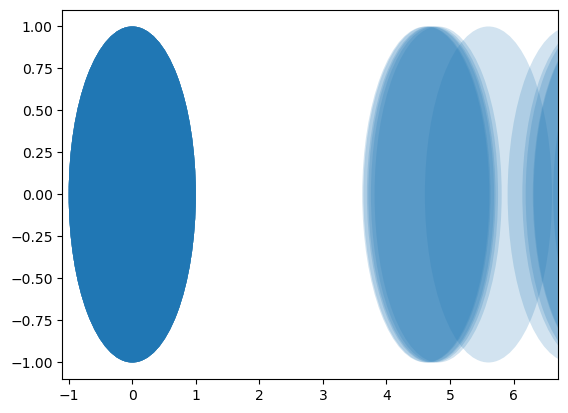

In [14]:
cosine_similarity(raw_data,'SEX',6,25)

cosine distance between MARRIAGE  and PAY_0 -0.007734807054950332
cosine distance between MARRIAGE  and PAY_2 -0.0975843214210077
cosine distance between MARRIAGE  and PAY_3 -0.12004676565067474
cosine distance between MARRIAGE  and PAY_4 -0.16541832017229474
cosine distance between MARRIAGE  and PAY_5 -0.2057013890451045
cosine distance between MARRIAGE  and PAY_6 -0.2219790687790486
cosine distance between MARRIAGE  and BILL_AMT1 0.535120466509041
cosine distance between MARRIAGE  and BILL_AMT2 0.533146912965392
cosine distance between MARRIAGE  and BILL_AMT3 0.5252861155209902
cosine distance between MARRIAGE  and BILL_AMT4 0.5227532292019536
cosine distance between MARRIAGE  and BILL_AMT5 0.5170362435062202
cosine distance between MARRIAGE  and BILL_AMT6 0.5124106476755194
cosine distance between MARRIAGE  and PAY_AMT1 0.30486393912635856
cosine distance between MARRIAGE  and PAY_AMT2 0.23341626376316682
cosine distance between MARRIAGE  and PAY_AMT3 0.2686051582423531
cosine dista

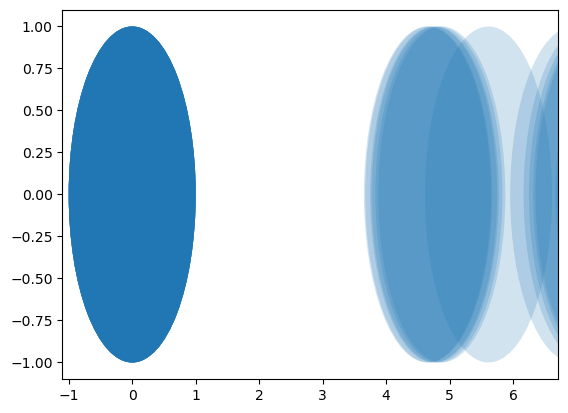

In [15]:
cosine_similarity(raw_data,'MARRIAGE',6,25)

cosine distance between default payment next month  and ID 0.40115550978898296
cosine distance between default payment next month  and LIMIT_BAL 0.288836447523904
cosine distance between default payment next month  and SEX 0.43957389201265396
cosine distance between default payment next month  and EDUCATION 0.019012219723353208
cosine distance between default payment next month  and MARRIAGE 0.4389320887083368
cosine distance between default payment next month  and AGE 0.4582936368100765
cosine distance between default payment next month  and PAY_0 0.279609256316948
cosine distance between default payment next month  and PAY_2 0.1789179580621184
cosine distance between default payment next month  and PAY_3 0.1409462779531856
cosine distance between default payment next month  and PAY_4 0.10061339025795413
cosine distance between default payment next month  and PAY_5 0.06782853096865171
cosine distance between default payment next month  and PAY_6 0.04445149277378457
cosine distance bet

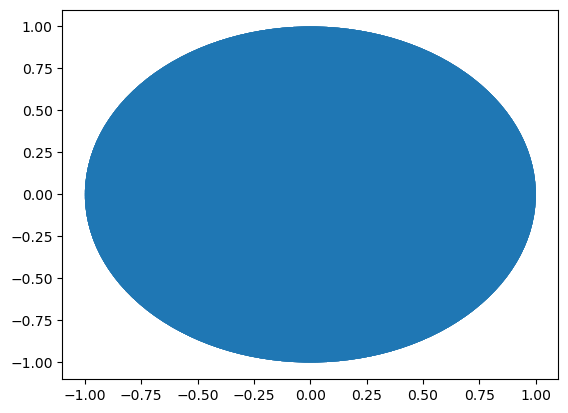

In [16]:
cosine_similarity(raw_data,'default payment next month',0,25)

cosine distance between EDUCATION  and PAY_0 -0.025314561967561877
cosine distance between EDUCATION  and PAY_2 -0.0440878424972877
cosine distance between EDUCATION  and PAY_3 -0.048885672812877035
cosine distance between EDUCATION  and PAY_4 -0.051470671595143624
cosine distance between EDUCATION  and PAY_5 -0.05377302427249453
cosine distance between EDUCATION  and PAY_6 -0.06167404607969673
cosine distance between EDUCATION  and BILL_AMT1 0.10198925003601145
cosine distance between EDUCATION  and BILL_AMT2 0.0971546315753622
cosine distance between EDUCATION  and BILL_AMT3 0.094505446079582
cosine distance between EDUCATION  and BILL_AMT4 0.08762876392511776
cosine distance between EDUCATION  and BILL_AMT5 0.0796083349773945
cosine distance between EDUCATION  and BILL_AMT6 0.07191516460912761
cosine distance between EDUCATION  and PAY_AMT1 0.04397786948302307
cosine distance between EDUCATION  and PAY_AMT2 0.04119710111805186
cosine distance between EDUCATION  and PAY_AMT3 0.055767

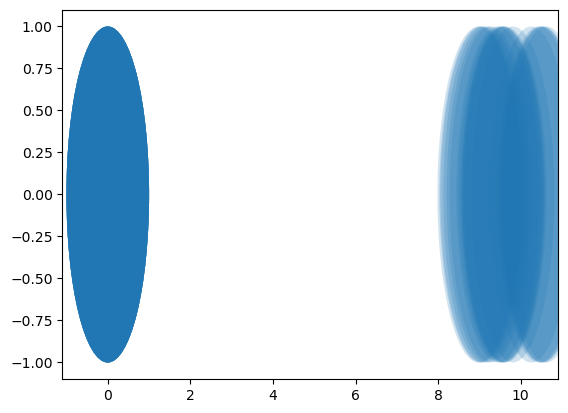

In [17]:
cosine_similarity(raw_data,'EDUCATION',6,25)

cosine distance between AGE  and PAY_0 -0.024298251544266236
cosine distance between AGE  and PAY_2 -0.12000819607712288
cosine distance between AGE  and PAY_3 -0.14633737647441913
cosine distance between AGE  and PAY_4 -0.19179771789188838
cosine distance between AGE  and PAY_5 -0.23451932511697504
cosine distance between AGE  and PAY_6 -0.24940218262820713
cosine distance between AGE  and BILL_AMT1 0.5643227867083552
cosine distance between AGE  and BILL_AMT2 0.5614412134139822
cosine distance between AGE  and BILL_AMT3 0.5542898811725712
cosine distance between AGE  and BILL_AMT4 0.5508339362195074
cosine distance between AGE  and BILL_AMT5 0.545205648798018
cosine distance between AGE  and BILL_AMT6 0.5390581107113878
cosine distance between AGE  and PAY_AMT1 0.31937640906542175
cosine distance between AGE  and PAY_AMT2 0.24621144087820668
cosine distance between AGE  and PAY_AMT3 0.28244313231187634
cosine distance between AGE  and PAY_AMT4 0.2900891282000462
cosine distance betwe

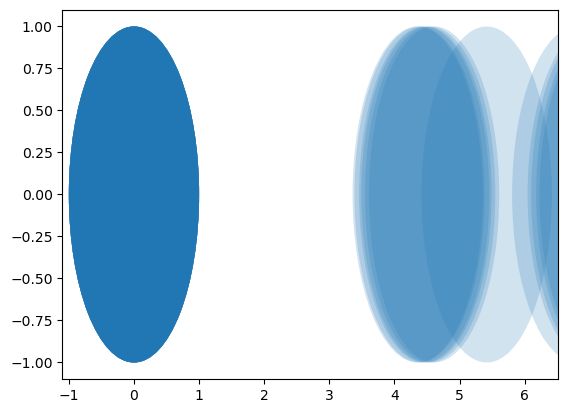

In [18]:
cosine_similarity(raw_data,'AGE',6,25)

#### No proxy feature. checked ok

#### check data bias

In [19]:
raw_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [192]:
pii_features=['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
for i in pii_features:
    print(i,' -> ', raw_data[i].unique())

SEX  ->  [2 1]
EDUCATION  ->  [0 1]
MARRIAGE  ->  [1 2 3 0]
AGE  ->  [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]


In [193]:
bin_edges = [21, 41, 61, 81]

# Create the bins
raw_data['age_bins'] = pd.cut(raw_data['AGE'], bin_edges)
raw_data['age_bins'].unique()


[(21.0, 41.0], (41.0, 61.0], (61.0, 81.0], NaN]
Categories (3, interval[int64, right]): [(21, 41] < (41, 61] < (61, 81]]

In [194]:
raw_data = raw_data.drop('AGE', axis=1)

In [195]:
raw_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'age_bins'],
      dtype='object')

In [196]:
def oneHotEnc(df,col_name):
    one_hot = pd.get_dummies(df[col_name], prefix=col_name)
    df = df.drop(col_name, axis=1)
    df = df.join(one_hot)
    return df

In [197]:
cols=['MARRIAGE', 'age_bins']
for i in cols:
    raw_data=oneHotEnc(raw_data,i)
raw_data

,ID,LIMIT_BAL,SEX,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT5,PAY_AMT6,default payment next month,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,"age_bins_(21, 41]","age_bins_(41, 61]","age_bins_(61, 81]"
0,1,20000,2,0,2,2,-1,-1,-2,-2,...,0,0,1,0,1,0,0,1,0,0
1,2,120000,2,0,-1,2,0,0,0,2,...,0,2000,1,0,0,1,0,1,0,0
2,3,90000,2,0,0,0,0,0,0,0,...,1000,5000,0,0,0,1,0,1,0,0
3,4,50000,2,0,0,0,0,0,0,0,...,1069,1000,0,0,1,0,0,1,0,0
4,5,50000,1,0,-1,0,-1,0,0,0,...,689,679,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,0,0,0,0,0,0,0,...,5000,1000,0,0,1,0,0,1,0,0
29996,29997,150000,1,0,-1,-1,-1,-1,0,0,...,0,0,0,0,0,1,0,0,1,0
29997,29998,30000,1,0,4,3,2,-1,0,0,...,2000,3100,1,0,0,1,0,1,0,0
29998,29999,80000,1,0,1,-1,0,0,0,-1,...,52964,1804,1,0,1,0,0,1,0,0


In [26]:
raw_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]'],
      dtype='object')

## Normalised Statistical Parity Difference and Disparate Impact for comparison for data bias

In [27]:
cols=['SEX', 'EDUCATION','MARRIAGE_0', 'MARRIAGE_1','MARRIAGE_2', 'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]']

In [28]:
def heatmap_protected(df,i):

    pivot=df.reset_index().pivot_table(index=i, columns='default payment next month', aggfunc='count')
#     print(pivot)
    ax = sns.heatmap(pivot, annot=True,fmt='g')
    plt.show()
    return pivot


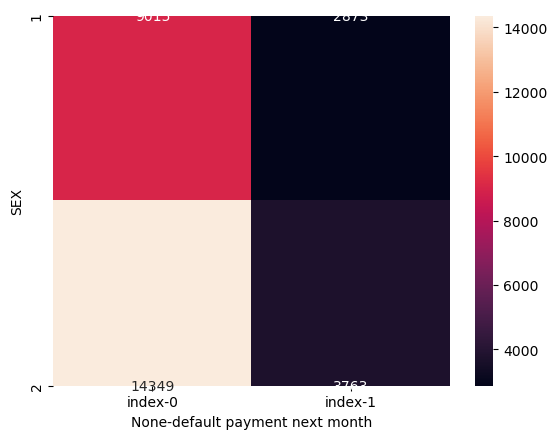

                            index      
default payment next month      0     1
SEX                                    
1                            9015  2873
2                           14349  3763


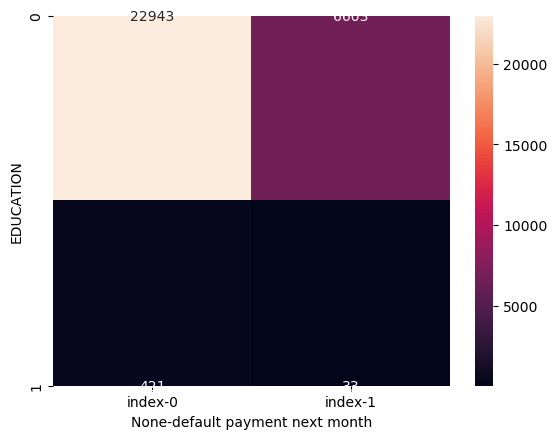

                            index      
default payment next month      0     1
EDUCATION                              
0                           22943  6603
1                             421    33


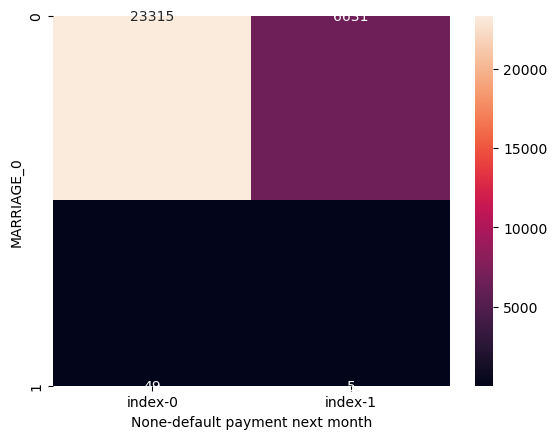

                            index      
default payment next month      0     1
MARRIAGE_0                             
0                           23315  6631
1                              49     5


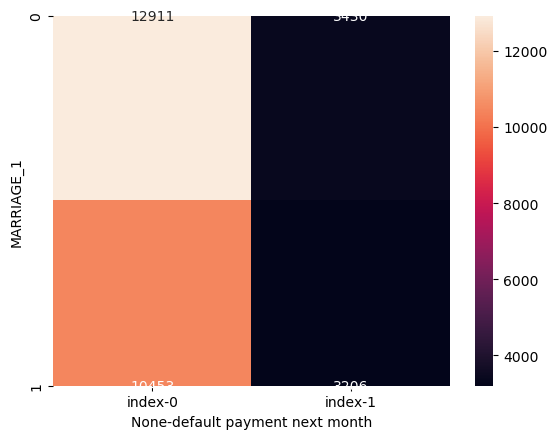

                            index      
default payment next month      0     1
MARRIAGE_1                             
0                           12911  3430
1                           10453  3206


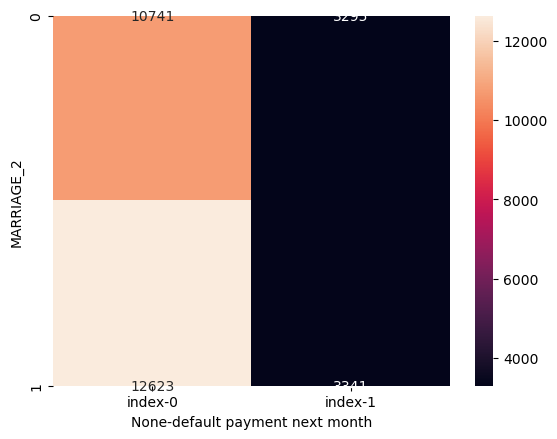

                            index      
default payment next month      0     1
MARRIAGE_2                             
0                           10741  3295
1                           12623  3341


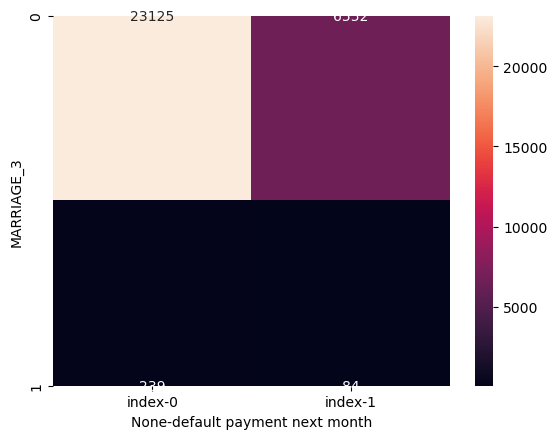

                            index      
default payment next month      0     1
MARRIAGE_3                             
0                           23125  6552
1                             239    84


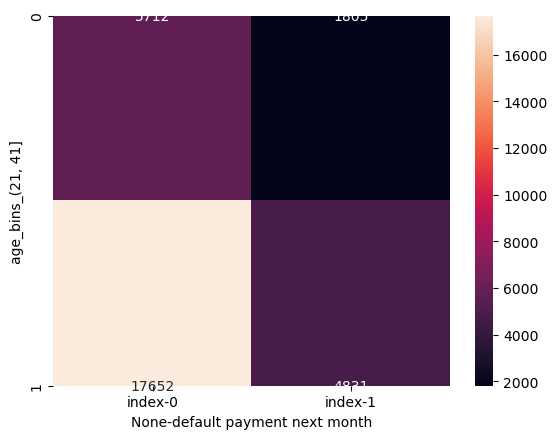

                            index      
default payment next month      0     1
age_bins_(21, 41]                      
0                            5712  1805
1                           17652  4831


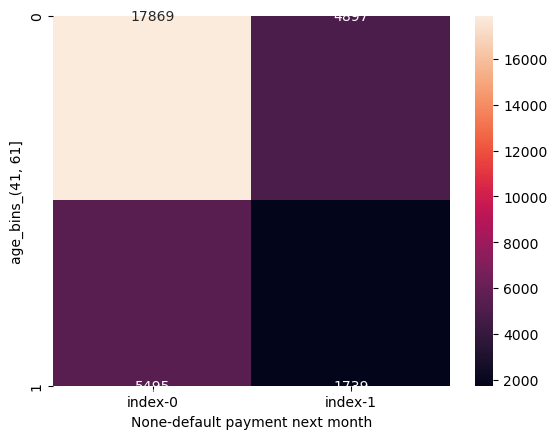

                            index      
default payment next month      0     1
age_bins_(41, 61]                      
0                           17869  4897
1                            5495  1739


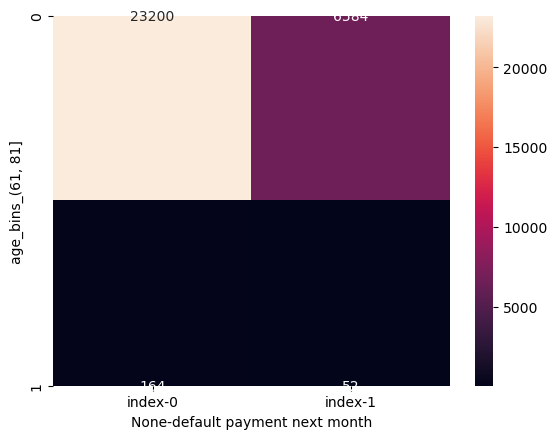

                            index      
default payment next month      0     1
age_bins_(61, 81]                      
0                           23200  6584
1                             164    52


In [29]:
for i in cols:
    print(heatmap_protected(raw_data[[i,'default payment next month']],i))

In [30]:
statistical_parity=[]
disparate_impact=[]

def statistical_parity_test(df,protected_group,Sa_label,Sd_label,y,fav_label):
    Sa=df[raw_data[protected_group] == Sa_label]
    fav_Sa=Sa[Sa[y] == fav_label]
    fav_Sa_count = len(fav_Sa)
    Sd=df[raw_data[protected_group] == Sd_label]
    fav_Sd=Sd[Sd[y] == fav_label]
    fav_Sd_count = len(fav_Sd)
    adv=len(Sa)
    disadv=len(Sd)
    statistical_parity.append((fav_Sd_count/disadv)-(fav_Sa_count/adv))
    disparate_impact.append((fav_Sd_count/disadv)/(fav_Sa_count/adv))
    
    

In [31]:

statistical_parity_test(raw_data,'SEX',2,1,'default payment next month',0)
statistical_parity_test(raw_data,'EDUCATION',0,1,'default payment next month',0)
statistical_parity_test(raw_data,'MARRIAGE_0',0,1,'default payment next month',0)
statistical_parity_test(raw_data,'MARRIAGE_1',0,1,'default payment next month',0)
statistical_parity_test(raw_data,'MARRIAGE_2',1,0,'default payment next month',0)
statistical_parity_test(raw_data,'MARRIAGE_3',0,1,'default payment next month',0)
statistical_parity_test(raw_data,'age_bins_(21, 41]',1,0,'default payment next month',0)
statistical_parity_test(raw_data,'age_bins_(41, 61]',0,1,'default payment next month',0)
statistical_parity_test(raw_data,'age_bins_(61, 81]',0,1,'default payment next month',0)



In [32]:
def plot_SPD_DI(cols,statistical_parity,disparate_impact):
    d = pd.DataFrame({'Protected_feature':cols,'Statistical_Parity':statistical_parity,'Disparate_Impact':disparate_impact})
    d['DI_normal']=d["Disparate_Impact"].apply(lambda x: 1/x if x < 1 else x)
    d['SP_normal']=d["Statistical_Parity"].apply(lambda x: abs(x) if x < 0 else x)

    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    fig.suptitle('Normalised Statistical Parity Difference and Disparate Impact for comparison', fontsize=40, y=1)

    width = 0.3
    ax.set_ylim(0, 0.25) 
    ax2.set_ylim(0, 1.5) 

    d.plot(x ='Protected_feature', y='SP_normal', kind = 'bar', ax=ax, width=width, 
           position=1, color='green', legend=False, figsize=(30,10), fontsize=20)
    d.plot(x ='Protected_feature', y='DI_normal', kind = 'bar', ax=ax2, width=width, 
           position=0, color='black', legend=False, figsize=(30,10), fontsize=20)

    ax.axhline(y=0.10, linestyle='dashed', linewidth=2, alpha=0.7, color='green')
    ax2.axhline(y=0.80, linestyle='dashed', linewidth=2, alpha=0.7, color='black')

    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, ['Stat Parity Diff'], loc='upper left', fontsize=25)

    patches, labels = ax2.get_legend_handles_labels()
    ax2.legend(patches, ['Disparate Impact'], loc='upper right', fontsize=25)

    labels = [item.get_text() for item in ax.get_xticklabels()]

    ax.set_xticklabels(labels)
    ax.set_xlabel('Protected Groups', fontsize=25)
    ax.set_ylabel('Statistical Parity Difference', fontsize=25)
    ax2.set_ylabel('Disparate Impact', fontsize=25)

    plt.show()

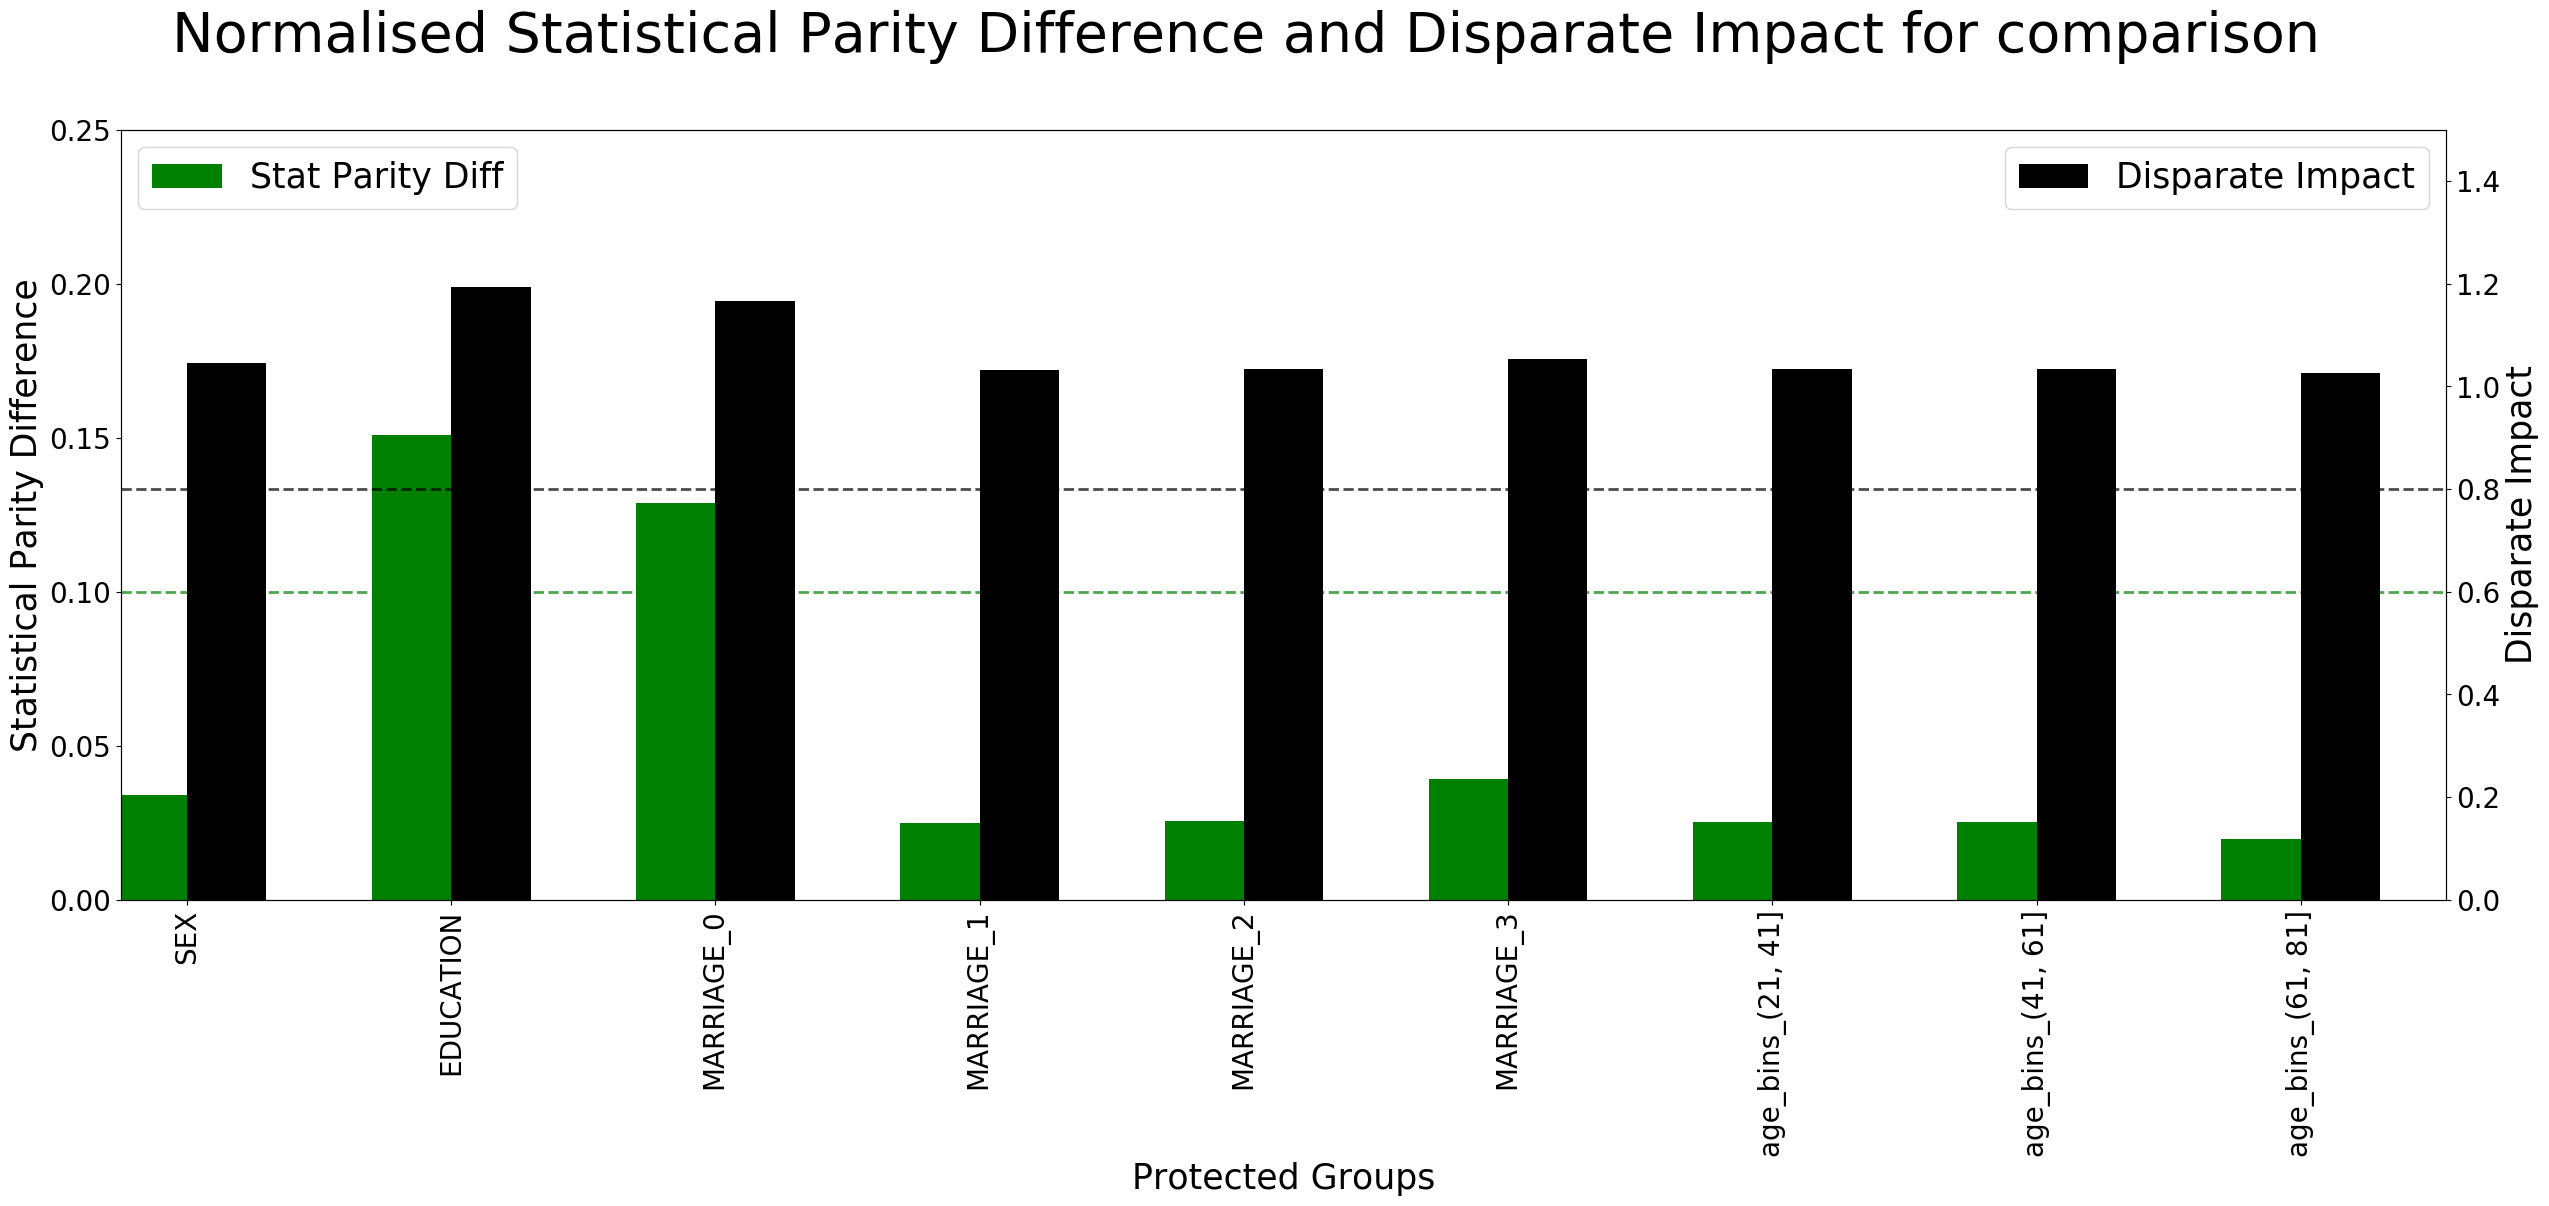

In [33]:
plot_SPD_DI(cols,statistical_parity,disparate_impact)

In [34]:
cols.append('Combined_protected_group')

In [35]:
raw_data['Combined_protected_group'] = np.where((raw_data['MARRIAGE_0'] == 0) & (raw_data['EDUCATION'] == 0),0, 1)

choice = 'Combined_protected_group'#'Combined_protected_group' #'NrOfDependantslessthan3'
pval = 1
upval = 0

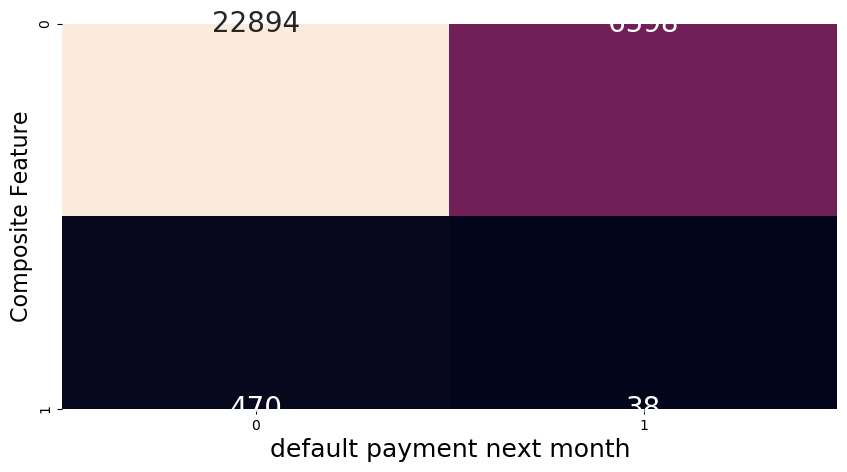

In [36]:
plt.subplots(figsize=(10,5))
plotdf=pd.crosstab(raw_data[choice], raw_data['default payment next month'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False, annot_kws={'size':20})    #axes.plot(vc)
plt.xlabel('default payment next month', fontsize=18)
plt.ylabel('Composite Feature', fontsize=16)

plt.show()    #axes.plot(vc)


In [37]:
statistical_parity_test(raw_data,'Combined_protected_group',0,1,'default payment next month',0)

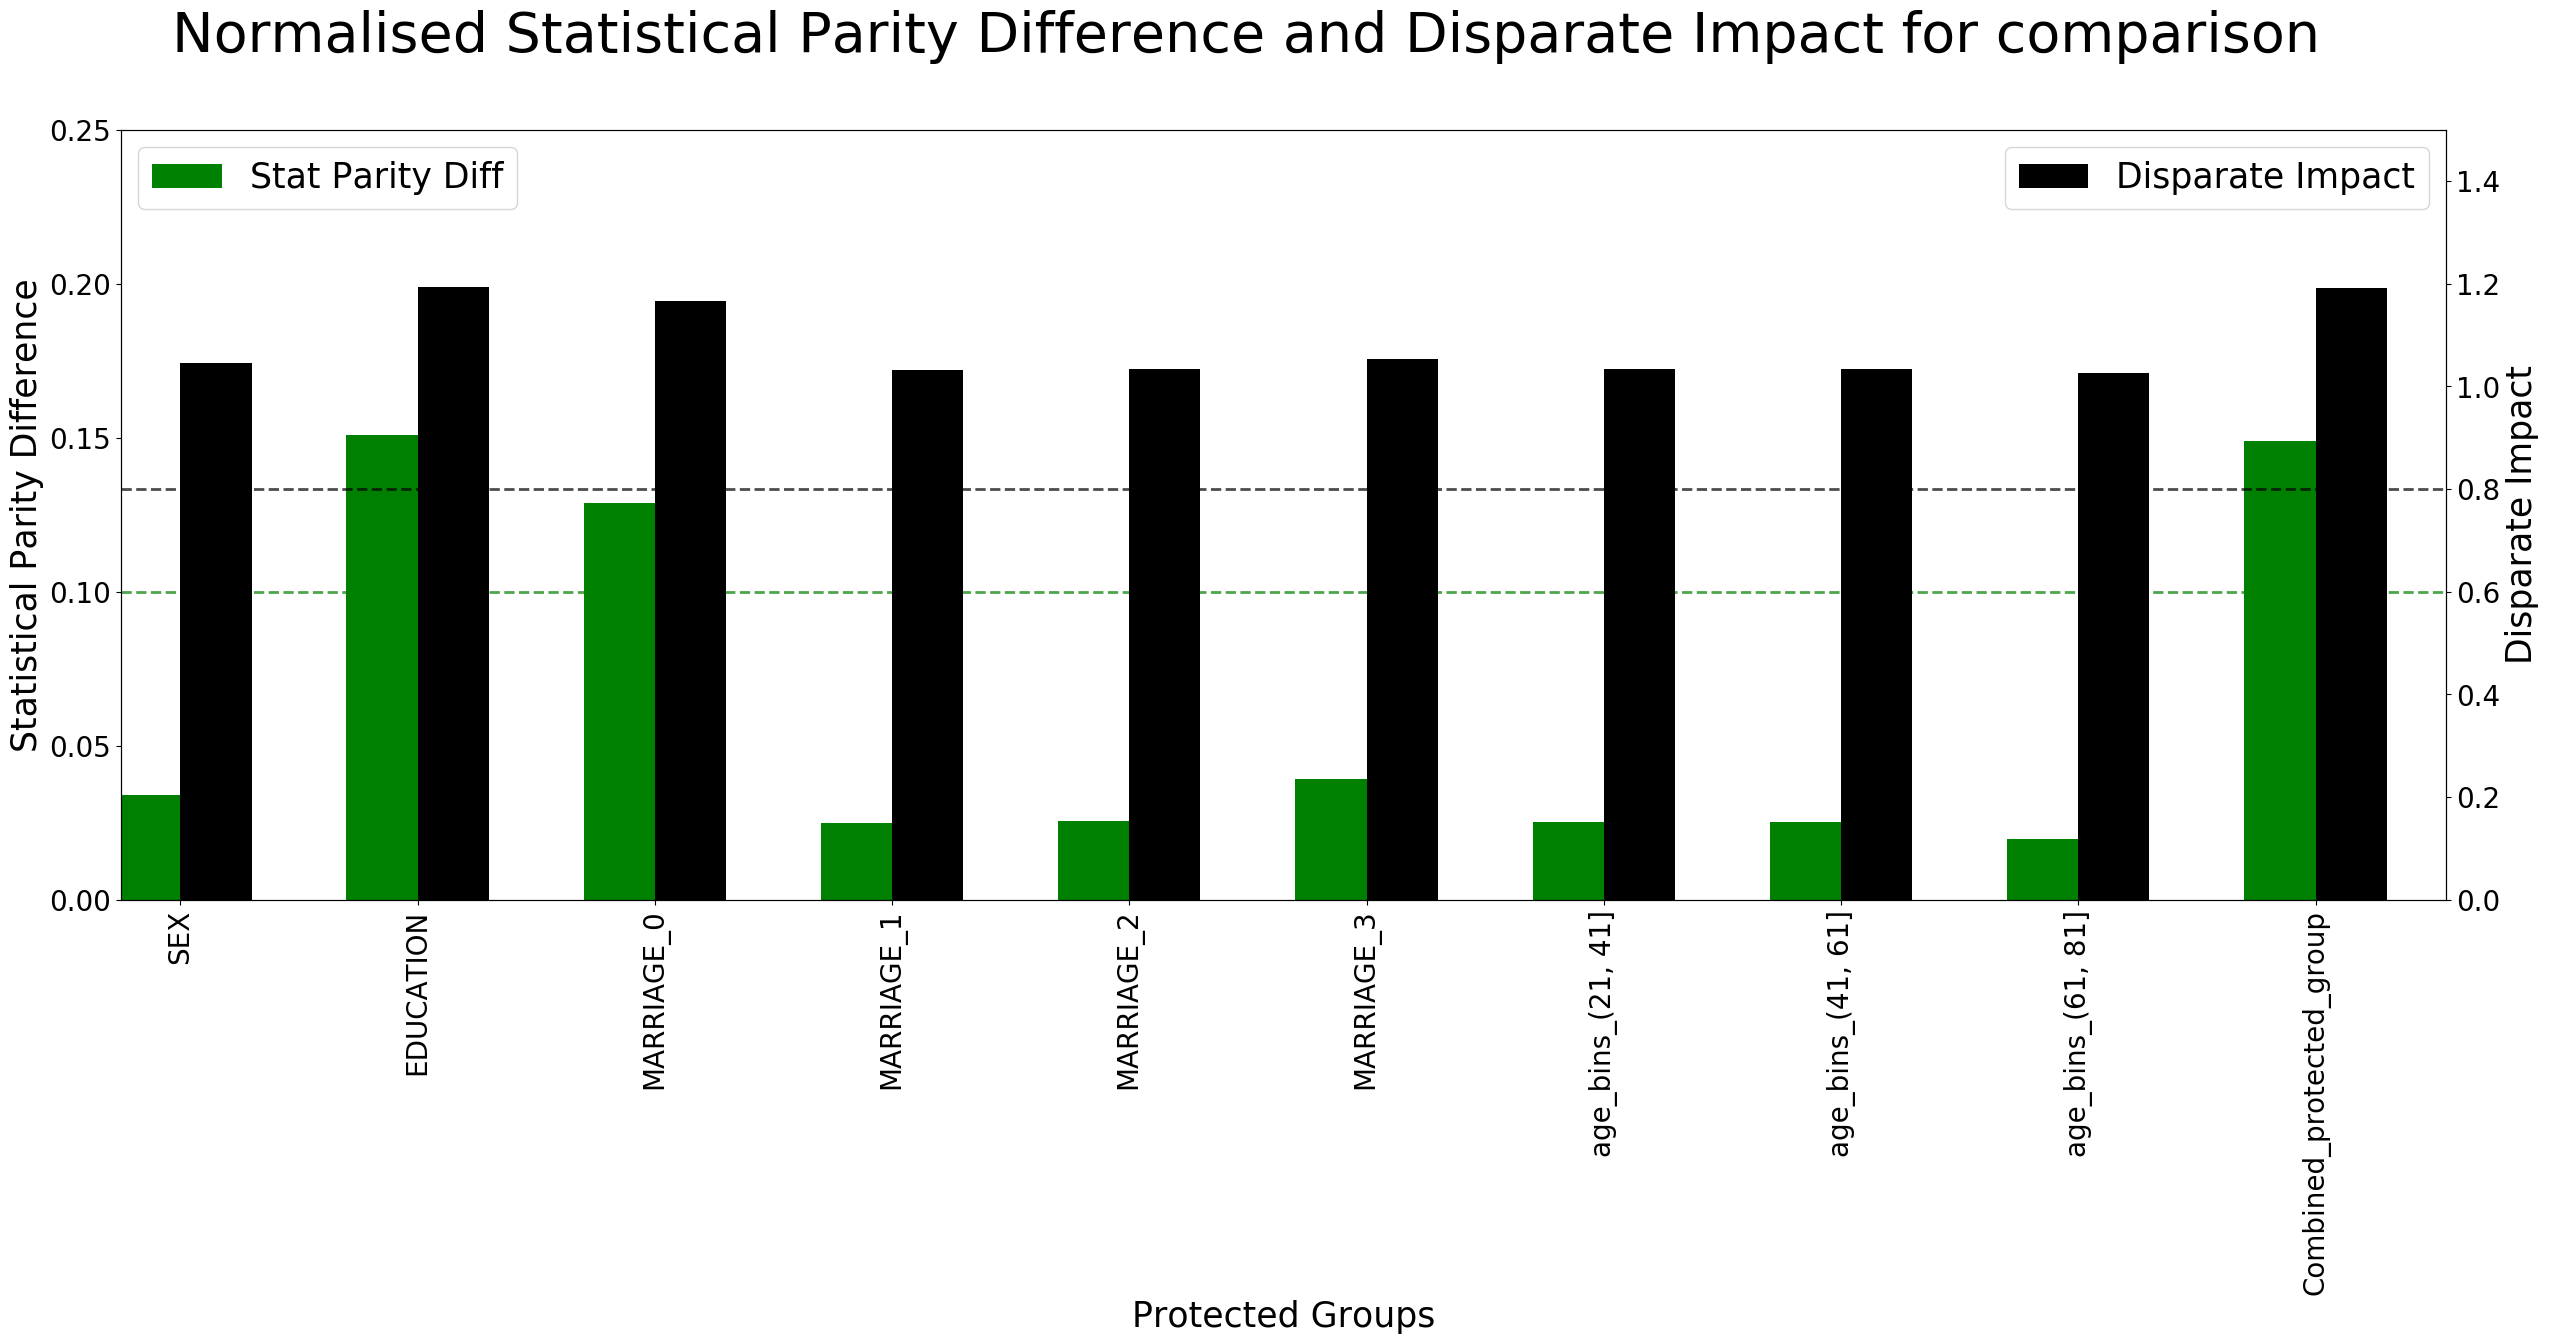

In [38]:
plot_SPD_DI(cols,statistical_parity,disparate_impact)

In [39]:
# reweighing on combine feature

In [198]:
def Reweighing1 (data, choice, target_feature, pval, upval, fav=0, unfav=1):


    dummy = np.repeat(1, len(data)) 
    data['dummy'] = dummy

    n = np.sum(data['dummy']) #Total number of instances
    sa = np.sum(data['dummy'][data[choice]==pval]) #Total number of privileged
    sd = np.sum(data['dummy'][data[choice]==upval]) #Total number of unprivileged
    ypos = np.sum(data['dummy'][data[target_feature]==fav]) #Total number of favourable
    yneg = np.sum(data['dummy'][data[target_feature]==unfav]) #Total number of unfavourable
    
    data_sa_ypos = data[(data[choice]==pval) & (data[target_feature]==fav)] # priviliged and favourable
    data_sa_yneg = data[(data[choice]==pval) & (data[target_feature]==unfav)] # priviliged and unfavourable
    data_sd_ypos = data[(data[choice]==upval) & (data[target_feature]==fav)] # unpriviliged and favourable
    data_sd_yneg = data[(data[choice]==upval) & (data[target_feature]==unfav)] # unpriviliged and unfavourable

    sa_ypos = np.sum(data_sa_ypos['dummy']) #Total number of privileged and favourable
    sa_yneg = np.sum(data_sa_yneg['dummy']) #Total number of privileged and unfavourable
    sd_ypos = np.sum(data_sd_ypos['dummy']) #Total number of unprivileged and favourable
    sd_yneg = np.sum(data_sd_yneg['dummy']) #Total number of unprivileged and unfavourable

    w_sa_ypos= (ypos*sa) / (n*sa_ypos) #weight for privileged and favourable
    w_sa_yneg = (yneg*sa) / (n*sa_yneg) #weight for privileged and unfavourable
    w_sd_ypos = (ypos*sd) / (n*sd_ypos) #weight for unprivileged and favourable
    w_sd_yneg = (yneg*sd) / (n*sd_yneg) #weight for unprivileged and unfavourable

    datatest=data #.copy()
    
#     print (w_sa_ypos, w_sa_yneg, w_sd_ypos, w_sd_yneg)
    
    DiscriminationBefore=(sa_ypos/sa)-(sd_ypos/sd)
    DiscriminationAfter=(sa_ypos/sa * w_sa_ypos)-(sd_ypos/sd * w_sd_ypos)


    print ("DiscriminationBefore: {} \nDiscriminationAfter: {}  ".format(DiscriminationBefore, DiscriminationAfter))
    
    datatest['NewWeights']= np.repeat(999, len(datatest)) 
    datatest.loc[(datatest[choice]==pval) & (datatest[target_feature]==fav), 'NewWeights'] = w_sa_ypos
    datatest.loc[(datatest[choice]==pval) & (datatest[target_feature]==unfav), 'NewWeights'] = w_sa_yneg
    datatest.loc[(datatest[choice]==upval) & (datatest[target_feature]==fav), 'NewWeights'] = w_sd_ypos
    datatest.loc[(datatest[choice]==upval) & (datatest[target_feature]==unfav), 'NewWeights'] = w_sd_yneg

    return datatest['NewWeights']

In [199]:
weighted_data = raw_data.copy(deep =True)

In [201]:
weighted_data['Weights']=Reweighing1(raw_data,'EDUCATION','default payment next month',1,0,0,1)

DiscriminationBefore: 0.15079480335449447 
DiscriminationAfter: 1.1102230246251565e-16  


### Differential privacy on protected variable

In [202]:
dp_limit_bal = raw_data.copy(deep =True)
dp_limit_bal_with_weight = weighted_data.copy(deep=True)

In [203]:
epsilon =0.5
sensitivity=1
dp_LIMIT_BAL=[]
dp_LIMIT_BAL_weight=[]
original_weighted=weighted_data['LIMIT_BAL']
original = raw_data['LIMIT_BAL']

for i in range(0,30000):
        value=original[i] +  np.random.laplace(loc=0, scale=sensitivity/epsilon)
        value = round(value)
        dp_LIMIT_BAL.append(value)
        value1=original_weighted[i] +  np.random.laplace(loc=0, scale=sensitivity/epsilon)
        value1 = round(value1)
        dp_LIMIT_BAL_weight.append(value1)
dp_limit_bal['LIMIT_BAL']=dp_LIMIT_BAL
dp_limit_bal_with_weight['LIMIT_BAL']=dp_LIMIT_BAL_weight

## 4 Datasets

In [204]:
raw_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]', 'dummy', 'NewWeights'],
      dtype='object')

In [205]:
PII_df=raw_data.copy(deep =True)

In [208]:
raw_data.drop(columns=['dummy', 'NewWeights','SEX', 'EDUCATION','MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]','age_bins_(61, 81]'],inplace=True)

In [209]:
raw_data.describe()['LIMIT_BAL']

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [210]:
dp_limit_bal.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]', 'dummy', 'NewWeights'],
      dtype='object')

In [211]:
PII__dp_df=dp_limit_bal.copy(deep=True)

In [212]:
dp_limit_bal.drop(columns=['dummy', 'NewWeights',
       'SEX', 'EDUCATION','MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]'],inplace=True)

In [213]:
dp_limit_bal.describe()['LIMIT_BAL'].apply(lambda x: format(x, 'f'))

count     30000.000000
mean     167484.327000
std      129747.660542
min        9991.000000
25%       50005.000000
50%      140001.000000
75%      239999.000000
max      999996.000000
Name: LIMIT_BAL, dtype: object

In [214]:
weighted_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]', 'Weights'],
      dtype='object')

In [215]:
PII__weighted_df=weighted_data.copy(deep=True)

In [216]:
weighted_data.drop(columns=[
    'SEX', 'EDUCATION','MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]','age_bins_(61, 81]'],inplace=True)

In [217]:
weighted_data.describe()['LIMIT_BAL']

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [218]:
dp_limit_bal_with_weight.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]', 'Weights'],
      dtype='object')

In [219]:
PII__weighted_dp_df=dp_limit_bal_with_weight.copy(deep=True)

In [220]:
dp_limit_bal_with_weight.drop(columns=[
       'SEX', 'EDUCATION','MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]','age_bins_(61, 81]'],inplace=True)

In [221]:
dp_limit_bal_with_weight.describe()['LIMIT_BAL'].apply(lambda x: format(x, 'f'))

count      30000.000000
mean      167484.316600
std       129747.668317
min         9989.000000
25%        50005.000000
50%       140000.000000
75%       239999.000000
max      1000001.000000
Name: LIMIT_BAL, dtype: object

In [223]:
# cols.remove('Combined_protected_group')

## Model

In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error

In [225]:
def split_data(df):
    x=df.drop("default payment next month", axis=1)

    y=df[['default payment next month']]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=6666)
    return X_train, X_test, y_train, y_test
    

In [226]:
cols


['MARRIAGE', 'age_bins']

In [227]:
def Accuracy_difference(X_test,y_test,model_name,model):
    y_pred_wow=model.predict(X_test)
    y_pred_prob_wow=model.predict_proba(X_test)[:,0]
    print("Accuracy of the model {} without weights:{}".format(model_name,model.score(X_test, y_test)))
    
#     for i in cols:
#         A_wow=model.score(X_test[X_test[i]==X_test[i].unique()[0]], y_test[X_test[i]==X_test[i].unique()[0]])
#         B_wow=model.score(X_test[X_test[i]==X_test[i].unique()[1]], y_test[X_test[i]==X_test[i].unique()[1]])
#         print("Accuracy difference between two groups {} :{}{} ".format(i,abs(B_wow-A_wow)*100 ,"%"))
    return y_pred_wow,y_pred_prob_wow

### Raw data on Random forest

In [228]:
X_train, X_test, y_train, y_test = split_data(raw_data)

clf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
# print("Accuracy of the model {} without weights:{}".format('Random Forest on raw data',clf.score(X_test, y_test)))
y_pred_raw_random,y_pred_prob_raw_random=Accuracy_difference(X_test,y_test,'Random Forest on raw data',clf)

Accuracy of the model Random Forest on raw data without weights:0.8146666666666667


## DP Data on random forest

In [229]:
X_train, X_test, y_train, y_test = split_data(dp_limit_bal)

clf_dp = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
# print("Accuracy of the model {} without weights:{}".format('Random Forest on raw data',clf_dp.score(X_test, y_test)))
y_pred_raw_dp_rand,y_pred_prob_raw_dp_rand=Accuracy_difference(X_test,y_test,'Random Forest on dp data',clf_dp)

Accuracy of the model Random Forest on dp data without weights:0.8151111111111111


## Weighted on random

In [230]:
X_train, X_test, y_train, y_test =split_data(weighted_data)
X_train_weights=X_train['Weights']
X_test_weights=X_test['Weights']

X_train1=X_train.drop(columns=["Weights"])
X_test1=X_test.drop(columns=["Weights"])

In [231]:
X_train_weights

6750     0.989789
17149    1.002939
22796    1.002939
12960    1.002939
23495    0.989789
           ...   
2150     1.002939
21145    1.002939
10335    1.002939
3857     1.002939
12209    1.002939
Name: Weights, Length: 21000, dtype: float64

In [232]:
clf_weighted_1 =RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train1, y_train , sample_weight=X_train_weights)
# print("Accuracy of the model {} without weights:{}".format('Random Forest on raw data',clf_weighted_1.score(X_test1, y_test)))
y_pred_weight_rand,y_pred_prob_weight_rand=Accuracy_difference(X_test1,y_test,'Random Forest on wegihted data',clf_weighted_1)

Accuracy of the model Random Forest on wegihted data without weights:0.8152222222222222


In [233]:
X_train, X_test, y_train, y_test =split_data(dp_limit_bal_with_weight)
X_train_weights=X_train['Weights']
X_test_weights=X_test['Weights']

X_train1=X_train.drop(columns=["Weights"])
X_test1=X_test.drop(columns=["Weights"])

 ## Weighted DP data on random forest

In [234]:
clf_weighted_1 =RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train1, y_train , sample_weight=X_train_weights)
# print("Accuracy of the model {} without weights:{}".format('Random Forest on raw data',clf_weighted_1.score(X_test1, y_test)))

y_pred_weight_dp_rand,y_pred_prob_weight_dp_rand=Accuracy_difference(X_test1,y_test,'Random Forest on wegihted DP data',clf_weighted_1)

Accuracy of the model Random Forest on wegihted DP data without weights:0.8162222222222222


In [235]:

def gini(actual, pred):
    """

    :param actual: actual values
    :param pred: predicted probablities
    :return: gini scores
    """
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

In [236]:
def gini_normalized(actual, pred):
    """

    :param actual: actual values
    :param pred: predicted probablities
    :return: normalized gini scores
    """
    return gini(actual, pred) / gini(actual, actual)

In [237]:
def model_perff(y_test, y_pred_prob_ww, y_pred_prob_wow, y_pred_ww, y_pred_wow, X_test1):
    
    model_perf=[model_metrics(y_test, y_pred_prob_ww, y_pred_prob_wow, 
                              y_pred_ww, y_pred_wow, X_test1)]

    headers=["AUC", "Gini", "Avg Precision Score", "Precision", "Sensitivity", "False Negative Rate", 
             "F1 Score", "Total Cost"]


    #full_metric={'With Weights':B, 
    #             'Without_Weights':list(ww[0]), 'Without_Weights':list(wow[0])}

    #compare_table=pd.DataFrame.from_dict(ww_wow)

    B = list(model_perf[0])[:len(list(model_perf[0]))//2]
    C = list(model_perf[0])[len(list(model_perf[0]))//2:]


    model_table={'Metrics':headers, 
                 'With_Weights':B, 'Without_Weights':C}

    model_table_df=pd.DataFrame.from_dict(model_table)
    model_table_df.loc[8] = ['Total Cost (in Mn)', model_table_df.iloc[7,1]/10000000, model_table_df.iloc[7,2]/10000000]
    return model_table_df

In [238]:
model_table_df_random_forest=model_perff(y_test,y_pred_prob_weight_rand,y_pred_prob_raw_random,y_pred_weight_rand,y_pred_raw_random,X_test1)

In [241]:
cols

['MARRIAGE', 'age_bins']

In [243]:
after_weight=[]
for choice in biased_protected_groups:
    if choice =='SEX':
        after_weight.append(fair_metrics(y_test, y_pred_prob_weight_rand, y_pred_weight_rand, X_test, choice, 1, 2))
    else:
        after_weight.append(fair_metrics(y_test, y_pred_prob_weight_rand, y_pred_weight_rand, X_test, choice, 0, 1))
    

KeyError: 'SEX'

In [ ]:
before_weight=[]
for choice in biased_protected_groups:
    if choice =='SEX':
        before_weight.append(fair_metrics(y_test, y_pred_prob_raw_random, y_pred_raw_random, X_test, choice, 1, 2))
    else:
        before_weight.append(fair_metrics(y_test, y_pred_prob_raw_random, y_pred_raw_random, X_test, choice, 0, 1))
    

In [ ]:
len(before_weight)

In [ ]:
len(after_weight)

In [ ]:
for i in range(0,len(after_weight)):
    labels, log_reg_model = zip(*after_weight[i])
    headers, acf_model = zip(*before_weight[i])
    Weight={'Metrics':headers, 
                 'Model with weight':list(log_reg_model), 'Model without weight':list(acf_model)}
    ACF_table=pd.DataFrame.from_dict(Weight)
    
    print(ACF_table)
    print("\n")
    ax = ACF_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['black', 'green'], figsize=(10,5), fontsize=12)
    
plt.show()

In [76]:
#plt.clf()
#plt.figure()
#Married, singlr, divorced
def plot_reweigh(model_table_df):
    txt='Composite feature'

    ax = model_table_df.iloc[[0,2,3,4,5,6,8],:].plot.bar(x='Metrics', rot=90, width = 0.7, 
                                                           color=['red', 'black'], figsize=(10,5), fontsize=12)
    plt.suptitle('Before and after reweighting: {}'.format(txt),  fontsize=16, y=1)



    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='upper right', fontsize=12)

    ax.set_xlabel('Accuracy metrics', fontsize=15)


    #plt.savefig('BnAR.svg', format='svg', dpi=500, bbox_inches='tight') #,
    #plt.savefig('BnAR.png', format='png', dpi=500, bbox_inches='tight')
    #beingsaved = plt.figure()
    #beingsaved.savefig('BnAR.eps', format='eps', dpi=500)

    plt.show()

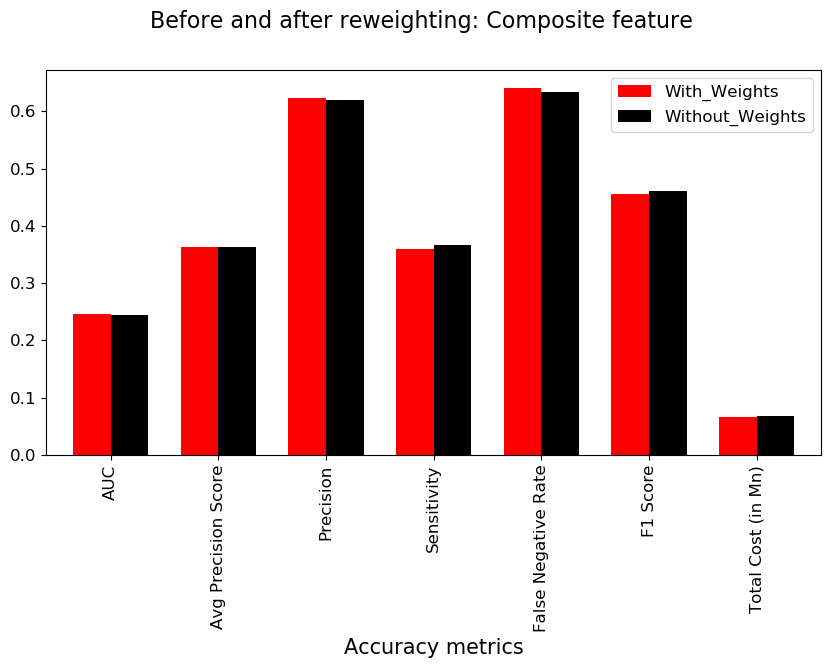

In [77]:
plot_reweigh(model_table_df_random_forest)

### ACF

In [78]:
raw_data.columns

Index(['ID', 'LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default payment next month'],
      dtype='object')

In [242]:
def data_acf(df)  :
    dataacf = df[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]']]
    return dataacf
biased_protected_groups = ['SEX','EDUCATION','MARRIAGE_0','MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'age_bins_(21, 41]', 'age_bins_(41, 61]',
       'age_bins_(61, 81]']

In [91]:
# raw_data=pd.concat([raw_data, PII_df], axis=1)

In [92]:
dataacf=data_acf(PII_df)

In [93]:
dataacf

,ID,LIMIT_BAL,SEX,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT5,PAY_AMT6,default payment next month,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,"age_bins_(21, 41]","age_bins_(41, 61]","age_bins_(61, 81]"
0,1,20000,2,0,2,2,-1,-1,-2,-2,...,0,0,1,0,1,0,0,1,0,0
1,2,120000,2,0,-1,2,0,0,0,2,...,0,2000,1,0,0,1,0,1,0,0
2,3,90000,2,0,0,0,0,0,0,0,...,1000,5000,0,0,0,1,0,1,0,0
3,4,50000,2,0,0,0,0,0,0,0,...,1069,1000,0,0,1,0,0,1,0,0
4,5,50000,1,0,-1,0,-1,0,0,0,...,689,679,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,0,0,0,0,0,0,0,...,5000,1000,0,0,1,0,0,1,0,0
29996,29997,150000,1,0,-1,-1,-1,-1,0,0,...,0,0,0,0,0,1,0,0,1,0
29997,29998,30000,1,0,4,3,2,-1,0,0,...,2000,3100,1,0,0,1,0,1,0,0
29998,29999,80000,1,0,1,-1,0,0,0,-1,...,52964,1804,1,0,1,0,0,1,0,0


In [94]:
# dataacf_dp=data_acf(dp_limit_bal)

## ACF on raw data

In [95]:
X_train, X_test, y_train, y_test =split_data(dataacf)

In [96]:
log_reg = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

In [86]:
y_pred=log_reg.predict(X_test)
y_pred_prob=log_reg.predict_proba(X_test)[:,0]
print("Accuracy of the baseline model:", log_reg.score(X_test, y_test))

Accuracy of the baseline model: 0.8181111111111111


In [87]:
def metrics(choices):
    for choice in choices:
        
        A_full=log_reg.score(X_test[X_test[choice]==0], y_test[X_test[choice]==0]) 
        B_full=log_reg.score(X_test[X_test[choice]==1], y_test[X_test[choice]==1]) 
        print("Accuracy difference between two groups:", abs(B_full-A_full)*100, "%")

In [88]:
X_test['SEX']

8818     2
26826    1
16017    2
2375     1
4721     2
        ..
17488    2
11453    2
4510     1
22630    2
5966     1
Name: SEX, Length: 9000, dtype: int64

In [89]:
X_test

,ID,LIMIT_BAL,SEX,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,"age_bins_(21, 41]","age_bins_(41, 61]","age_bins_(61, 81]"
8818,8819,220000,2,0,0,0,0,0,0,0,...,9000,21000,0,0,1,0,0,1,0,0
26826,26827,20000,1,0,1,2,3,2,3,2,...,0,300,0,0,0,1,0,1,0,0
16017,16018,50000,2,0,0,0,0,0,0,0,...,1009,1000,1000,0,1,0,0,1,0,0
2375,2376,40000,1,0,2,2,2,2,2,2,...,3500,4471,0,0,1,0,0,1,0,0
4721,4722,240000,2,0,0,0,0,0,0,0,...,1860,1800,2000,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17488,17489,50000,2,0,0,0,0,0,-2,-2,...,0,0,0,0,1,0,0,0,1,0
11453,11454,140000,2,0,-1,-1,-1,-1,-2,-2,...,0,0,0,0,0,1,0,0,1,0
4510,4511,10000,1,0,-1,-1,-1,-1,-1,-1,...,390,0,780,0,0,1,0,1,0,0
22630,22631,200000,2,1,1,-2,-1,-1,-2,-1,...,0,89,0,0,1,0,0,1,0,0


In [98]:
# metrics(biased_protected_groups)

In [99]:
sens=X_train[biased_protected_groups]

In [100]:
from sklearn.linear_model import LinearRegression

In [101]:
acf_LIMIT_BAL = RandomForestClassifier().fit(sens, X_train['LIMIT_BAL'])
acf_PAY_0 =RandomForestClassifier().fit(sens, X_train['PAY_0'])
acf_PAY_2 = RandomForestClassifier().fit(sens, X_train['PAY_2'])
acf_PAY_3 = RandomForestClassifier().fit(sens, X_train['PAY_3'])
acf_PAY_4 = RandomForestClassifier().fit(sens, X_train['PAY_4'])
acf_IPAY_5 = RandomForestClassifier().fit(sens, X_train['PAY_5'])
acf_PAY_6 = RandomForestClassifier().fit(sens, X_train['PAY_6'])
acf_BILL_AMT1 = RandomForestClassifier().fit(sens, X_train['BILL_AMT1'])
acf_BILL_AMT2 = RandomForestClassifier().fit(sens, X_train['BILL_AMT2'])
acf_BILL_AMT3 = RandomForestClassifier().fit(sens, X_train['BILL_AMT3'])
acf_BILL_AMT4 = RandomForestClassifier().fit(sens, X_train['BILL_AMT4'])
acf_BILL_AMT5 = RandomForestClassifier().fit(sens, X_train['BILL_AMT5'])
acf_BILL_AMT6 = RandomForestClassifier().fit(sens, X_train['BILL_AMT6'])
acf_PAY_AMT1 = RandomForestClassifier().fit(sens, X_train['PAY_AMT1'])
acf_PAY_AMT2 = RandomForestClassifier().fit(sens, X_train['PAY_AMT2'])
acf_PAY_AMT3 = RandomForestClassifier().fit(sens, X_train['PAY_AMT3'])
acf_PAY_AMT4 = RandomForestClassifier().fit(sens, X_train['PAY_AMT4'])
acf_PAY_AMT5 = RandomForestClassifier().fit(sens, X_train['PAY_AMT5'])
acf_PAY_AMT6 = RandomForestClassifier().fit(sens, X_train['PAY_AMT6'])

In [102]:
sens_test=X_test[biased_protected_groups]

In [103]:
limit_balR =  X_train['LIMIT_BAL'] - acf_LIMIT_BAL.predict(sens)
acf_PAY_0R =X_train['PAY_0'] - acf_PAY_0.predict(sens)
acf_PAY_2R = X_train['PAY_2'] - acf_PAY_2.predict(sens)
acf_PAY_3R = X_train['PAY_3'] - acf_PAY_3.predict(sens)
acf_PAY_4R = X_train['PAY_4'] - acf_PAY_4.predict(sens)
acf_IPAY_5R = X_train['PAY_5'] - acf_IPAY_5.predict(sens)
acf_BILL_AMT1R = X_train['BILL_AMT1'] - acf_BILL_AMT1.predict(sens)
acf_BILL_AMT2R = X_train['BILL_AMT2'] - acf_BILL_AMT2.predict(sens)
acf_BILL_AMT3R = X_train['BILL_AMT3'] - acf_BILL_AMT3.predict(sens)
acf_BILL_AMT4R = X_train['BILL_AMT4'] - acf_BILL_AMT4.predict(sens)
acf_BILL_AMT5R = X_train['BILL_AMT5'] - acf_BILL_AMT5.predict(sens)
acf_BILL_AMT6R = X_train['BILL_AMT6'] - acf_BILL_AMT6.predict(sens)
acf_PAY_AMT1R = X_train['PAY_AMT1'] - acf_PAY_AMT1.predict(sens)
acf_PAY_AMT2R = X_train['PAY_AMT2'] - acf_PAY_AMT2.predict(sens)
acf_PAY_AMT3R = X_train['PAY_AMT3'] - acf_PAY_AMT3.predict(sens)
acf_PAY_AMT4R = X_train['PAY_AMT4'] - acf_PAY_AMT4.predict(sens)
acf_PAY_AMT5R = X_train['PAY_AMT5'] - acf_PAY_AMT5.predict(sens)
acf_PAY_AMT6R = X_train['PAY_AMT6'] - acf_PAY_AMT6.predict(sens)

In [104]:
df_R=pd.DataFrame({'limit_balR':limit_balR, 'acf_PAY_0R':acf_PAY_0R, 'acf_PAY_2R':acf_PAY_2R, 
                   'acf_PAY_3R':acf_PAY_3R,
                'acf_PAY_4R':acf_PAY_4R, 'acf_IPAY_5R':acf_IPAY_5R, 'acf_BILL_AMT1R':acf_BILL_AMT1R,
                   'acf_BILL_AMT2R':acf_BILL_AMT2R,'acf_BILL_AMT3R':acf_BILL_AMT3R,'acf_BILL_AMT4R':acf_BILL_AMT4R,
                  'acf_BILL_AMT5R':acf_BILL_AMT5R,'acf_BILL_AMT6R':acf_BILL_AMT6R, 'acf_PAY_AMT1R':acf_PAY_AMT1R,'acf_PAY_AMT2R':acf_PAY_AMT2R,
                  'acf_PAY_AMT3R':acf_PAY_AMT3R,'acf_PAY_AMT4R':acf_PAY_AMT4R,'acf_PAY_AMT5R':acf_PAY_AMT5R,'acf_PAY_AMT6R':acf_PAY_AMT6R})

In [105]:
fair = RandomForestClassifier(n_estimators=100, random_state=42).fit(df_R, y_train)

In [106]:
sens_test=X_test[biased_protected_groups]

In [107]:
limit_balR =  X_test['LIMIT_BAL'] - acf_LIMIT_BAL.predict(sens_test)
acf_PAY_0R =X_test['PAY_0'] - acf_PAY_0.predict(sens_test)
acf_PAY_2R = X_test['PAY_2'] - acf_PAY_2.predict(sens_test)
acf_PAY_3R = X_test['PAY_3'] - acf_PAY_3.predict(sens_test)
acf_PAY_4R = X_test['PAY_4'] - acf_PAY_4.predict(sens_test)
acf_IPAY_5R = X_test['PAY_5'] - acf_IPAY_5.predict(sens_test)
acf_BILL_AMT1R = X_test['BILL_AMT1'] - acf_BILL_AMT1.predict(sens_test)
acf_BILL_AMT2R = X_test['BILL_AMT2'] - acf_BILL_AMT2.predict(sens_test)
acf_BILL_AMT3R = X_test['BILL_AMT3'] - acf_BILL_AMT3.predict(sens_test)
acf_BILL_AMT4R = X_test['BILL_AMT4'] - acf_BILL_AMT4.predict(sens_test)
acf_BILL_AMT5R = X_test['BILL_AMT5'] - acf_BILL_AMT5.predict(sens_test)
acf_BILL_AMT6R = X_test['BILL_AMT6'] - acf_BILL_AMT6.predict(sens_test)
acf_PAY_AMT1R = X_test['PAY_AMT1'] - acf_PAY_AMT1.predict(sens_test)
acf_PAY_AMT2R = X_test['PAY_AMT2'] - acf_PAY_AMT2.predict(sens_test)
acf_PAY_AMT3R = X_test['PAY_AMT3'] - acf_PAY_AMT3.predict(sens_test)
acf_PAY_AMT4R = X_test['PAY_AMT4'] - acf_PAY_AMT4.predict(sens_test)
acf_PAY_AMT5R = X_test['PAY_AMT5'] - acf_PAY_AMT5.predict(sens_test)
acf_PAY_AMT6R = X_test['PAY_AMT6'] - acf_PAY_AMT6.predict(sens_test)

In [108]:
df_R_test=pd.DataFrame({'limit_balR':limit_balR, 'acf_PAY_0R':acf_PAY_0R, 'acf_PAY_2R':acf_PAY_2R, 
                   'acf_PAY_3R':acf_PAY_3R,
                'acf_PAY_4R':acf_PAY_4R, 'acf_IPAY_5R':acf_IPAY_5R, 'acf_BILL_AMT1R':acf_BILL_AMT1R,
                   'acf_BILL_AMT2R':acf_BILL_AMT2R,'acf_BILL_AMT3R':acf_BILL_AMT3R,'acf_BILL_AMT4R':acf_BILL_AMT4R,
                  'acf_BILL_AMT5R':acf_BILL_AMT5R,'acf_BILL_AMT6R':acf_BILL_AMT6R, 'acf_PAY_AMT1R':acf_PAY_AMT1R,'acf_PAY_AMT2R':acf_PAY_AMT2R,
                  'acf_PAY_AMT3R':acf_PAY_AMT3R,'acf_PAY_AMT4R':acf_PAY_AMT4R,'acf_PAY_AMT5R':acf_PAY_AMT5R,'acf_PAY_AMT6R':acf_PAY_AMT6R})

In [109]:
y_pred_fair = fair.predict(df_R_test)
y_pred_prob_fair = fair.predict_proba(df_R_test)

In [110]:
print("Accuracy of the fair model:", fair.score(df_R_test, y_test))

Accuracy of the fair model: 0.8127777777777778


In [116]:
X_test

,ID,LIMIT_BAL,SEX,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,"age_bins_(21, 41]","age_bins_(41, 61]","age_bins_(61, 81]"
8818,8819,220000,2,0,0,0,0,0,0,0,...,9000,21000,0,0,1,0,0,1,0,0
26826,26827,20000,1,0,1,2,3,2,3,2,...,0,300,0,0,0,1,0,1,0,0
16017,16018,50000,2,0,0,0,0,0,0,0,...,1009,1000,1000,0,1,0,0,1,0,0
2375,2376,40000,1,0,2,2,2,2,2,2,...,3500,4471,0,0,1,0,0,1,0,0
4721,4722,240000,2,0,0,0,0,0,0,0,...,1860,1800,2000,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17488,17489,50000,2,0,0,0,0,0,-2,-2,...,0,0,0,0,1,0,0,0,1,0
11453,11454,140000,2,0,-1,-1,-1,-1,-2,-2,...,0,0,0,0,0,1,0,0,1,0
4510,4511,10000,1,0,-1,-1,-1,-1,-1,-1,...,390,0,780,0,0,1,0,1,0,0
22630,22631,200000,2,1,1,-2,-1,-1,-2,-1,...,0,89,0,0,1,0,0,1,0,0


In [119]:
logistic_reg_fair_metrics=[]
for choice in biased_protected_groups:
    if choice =='SEX':
        logistic_reg_fair_metrics.append(fair_metrics(y_test, y_pred_prob, y_pred, X_test, choice, 1, 2))
    else:
        logistic_reg_fair_metrics.append(fair_metrics(y_test, y_pred_prob, y_pred, X_test, choice, 0, 1))
    

In [122]:
acf_metrics=[]
for choice in biased_protected_groups:
    if choice == 'SEX':
        tn_disadv, fp_disadv, fn_disadv, tp_disadv = confusion_matrix(y_test[sens_test[choice]==2], y_pred_fair[sens_test[choice]==2]).ravel()
        tn_adv, fp_adv, fn_adv, tp_adv = confusion_matrix(y_test[sens_test[choice]==1], y_pred_fair[sens_test[choice]==1]).ravel()
    else:
        tn_disadv, fp_disadv, fn_disadv, tp_disadv = confusion_matrix(y_test[sens_test[choice]==1], y_pred_fair[sens_test[choice]==1]).ravel()
        tn_adv, fp_adv, fn_adv, tp_adv = confusion_matrix(y_test[sens_test[choice]==0], y_pred_fair[sens_test[choice]==0]).ravel()

    acf_metrics.append(acf_fair_metrics(tn_disadv, fp_disadv, fn_disadv, tp_disadv, tn_adv, fp_adv, fn_adv, tp_adv))

    

Education
      Metrics  Baseline Model  ACF Fair Model
0  Equal Opps        0.030091        0.017674
1      PredEq        0.013555        0.006621
2  Equal Odds        0.043646        0.024294
3  DemoParity        0.024852        0.016352
4         AOD        0.021823        0.012147


MARRIAGE_0
      Metrics  Baseline Model  ACF Fair Model
0  Equal Opps        0.274515        0.263646
1      PredEq        0.014325        0.009525
2  Equal Odds        0.288841        0.273171
3  DemoParity        0.077336        0.070087
4         AOD        0.144420        0.136585




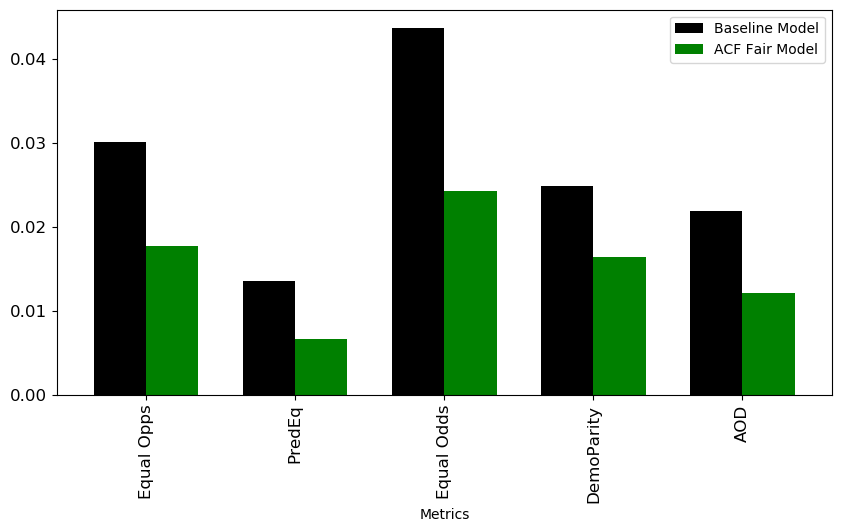

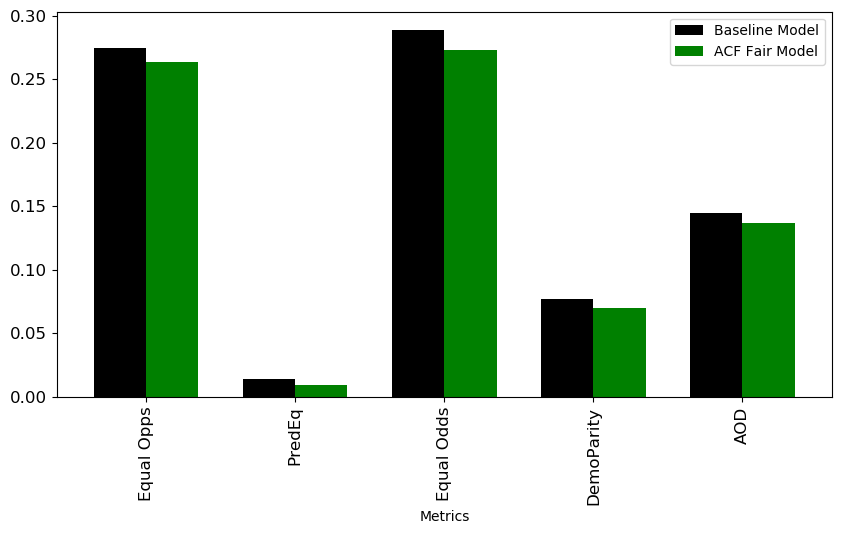

In [123]:
    
for i in range(0,2):
    labels, log_reg_model = zip(*logistic_reg_fair_metrics[i])
    headers, acf_model = zip(*acf_metrics[i])
    ACF={'Metrics':headers, 
                 'Baseline Model':list(log_reg_model), 'ACF Fair Model':list(acf_model)}
    ACF_table=pd.DataFrame.from_dict(ACF)
    print("Education" if i == 0 else "MARRIAGE_0")
    print(ACF_table)
    print("\n")
    ax = ACF_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['black', 'green'], figsize=(10,5), fontsize=12)
    
plt.show()

In [124]:
# def Rjopt(DECISION_THRESHOLD, theta, choice, pred_prob, X_test, pval = 0, demote = True):
#     upval = int(not pval) #Unprivileged
#     pred_prob = y_pred_prob.copy() #probabilities of getting output as 0 or favourable (high probability high case of 0 or fav)
#     s = X_test[choice]
    
#     flip_candidates = np.ones_like(pred_prob).astype(bool) if demote else s == upval #unprivileged group
#     np.sum(flip_candidates)
    
#     under_theta_index = np.where(
#             (np.abs(pred_prob - 0.5) < theta) & flip_candidates) 
#     #finding unprivileged & unfavourable within the threshold limit as defined by theta
    
#     pred_prob[under_theta_index] = 1 - pred_prob[under_theta_index] #flipping the probabilities
    
#     rocdata = pred_prob.copy()
#     rocbin=np.where(rocdata > DECISION_THRESHOLD, 0, 1)
    
#     fpr, tpr, _ = roc_curve(y_test, rocdata, pos_label=0)
#     print('ROC:', auc(fpr, tpr))


#     fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=0)
#     print('base:', auc(fpr, tpr))
    
    
    
#     return rocbin, pred_prob

In [125]:
D_Boundary = 0.5
theta = 0.1
penalise = True
pval = 0
upval = int(not pval) #Unprivileged

In [126]:
biased_protected_groups=['EDUCATION']

In [244]:
pred_prob = y_pred_prob.copy()

     #p
roc=pd.DataFrame()
roc_df = pd.DataFrame(pred_prob, columns=['pred_prob'])
roc_df['y_pred_original'] = y_pred_prob
roc_df['y_pred'] = y_pred
roc_df['y_test'] = y_test.reset_index(drop=True)
roc_df['S'] = X_test['EDUCATION'].reset_index(drop=True)

print(roc_df.head())
print("\n")

KeyError: 'EDUCATION'

In [128]:
if penalise==True:
    RO_df = roc_df[(np.abs(pred_prob - 0.5) < theta)]
else:
    RO_df = roc_df[(np.abs(pred_prob - 0.5) < theta) & (y_pred==fav)]


In [129]:
RO_df.head()

,pred_prob,y_pred_original,y_pred,y_test,S
3,0.42,0.42,1,1,0
10,0.55,0.55,0,0,0
11,0.42,0.42,1,0,0
12,0.53,0.53,0,1,0
20,0.53,0.53,0,1,0


In [130]:
pval_fav = RO_df[(RO_df['S']==0) & (RO_df['y_pred']==0)]
pval_ufav = RO_df[(RO_df['S']==0) & (RO_df['y_pred']==1)]
upval_fav = RO_df[(RO_df['S']==1) & (RO_df['y_pred']==0)]
upval_ufav = RO_df[(RO_df['S']==1) & (RO_df['y_pred']==1)]

In [131]:
pval_fav['pred_prob'] = 1- pval_fav['pred_prob']
upval_ufav['pred_prob'] = 1-upval_ufav['pred_prob']

In [132]:
RO_changed = pd.concat([pval_fav, pval_ufav, upval_fav, upval_ufav])
RO_changed.head()

,pred_prob,y_pred_original,y_pred,y_test,S
10,0.45,0.55,0,0,0
12,0.47,0.53,0,1,0
20,0.47,0.53,0,1,0
54,0.45,0.55,0,0,0
61,0.46,0.54,0,1,0


In [133]:
df = roc_df
df.loc[list(RO_changed.index), 'pred_prob']=RO_changed['pred_prob']

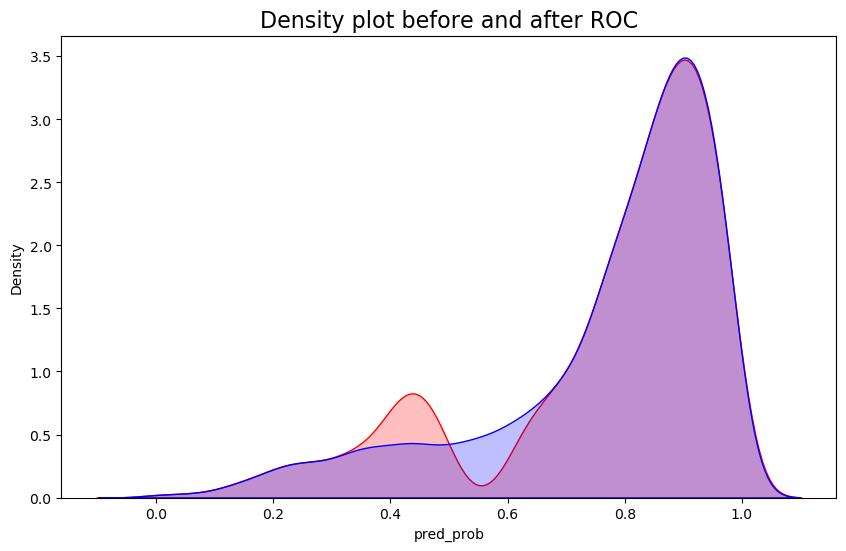

In [137]:
plt.figure(figsize=(10,6))
p1=sns.kdeplot(df['pred_prob'], shade=True, color="r")
p1=sns.kdeplot(df['y_pred_original'], shade=True, color="b")
plt.title('Density plot before and after ROC', fontsize=16)
plt.show()

In [138]:
df['rocdata']=df['pred_prob'].copy()
df['rocbin']=np.where(df['rocdata'] > 0.5, 0, 1)

In [139]:
from sklearn.metrics import roc_curve, auc
print (choice)
fpr, tpr, _ = roc_curve(df['y_test'], df['y_pred_original'].values, pos_label=0)
ROC = auc(fpr, tpr)
print('Original:', ROC)


fpr, tpr, _ = roc_curve(df['y_test'], df['pred_prob'].values, pos_label=0)
base = auc(fpr, tpr)
print('After ROC:', base)

print('ratio', base/ROC)

print ()

age_bins_(61, 81]
Original: 0.7574914757422302
After ROC: 0.7570341672628099
ratio 0.9993962856427233



In [140]:
tn_up, fp_up, fn_up, tp_up = confusion_matrix(df['y_test'][df['S']==upval], df['rocbin'][df['S']==upval]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(df['y_test'][df['S']==pval], df['rocbin'][df['S']==pval]).ravel()
Fullmodel = acf_fair_metrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

tn_up, fp_up, fn_up, tp_up = confusion_matrix(df['y_test'][df['S']==upval], df['y_pred'][df['S']==upval]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(df['y_test'][df['S']==pval], df['y_pred'][df['S']==pval]).ravel()
ROC = acf_fair_metrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

In [141]:
Fullmodel

[('Equal Opps', 0.15506616502335235),
 ('PredEq', 0.07353971709053475),
 ('Equal Odds', 0.2286058821138871),
 ('DemoParity', 0.0787684334375158),
 ('AOD', 0.11430294105694355)]

In [142]:
labels, Fullmodel1 = zip(*Fullmodel)
headers, ROC1 = zip(*ROC)
ROC2={'Metrics':headers, 
             'Full Model':list(Fullmodel1), 'ROC Fair Model':list(ROC1)}
ROC_table=pd.DataFrame.from_dict(ROC2)

In [143]:
ROC_table

,Metrics,Full Model,ROC Fair Model
0,Equal Opps,0.155066,0.074241
1,PredEq,0.073540,0.008449
2,Equal Odds,0.228606,0.082691
3,DemoParity,0.078768,0.038444
4,AOD,0.114303,0.041345


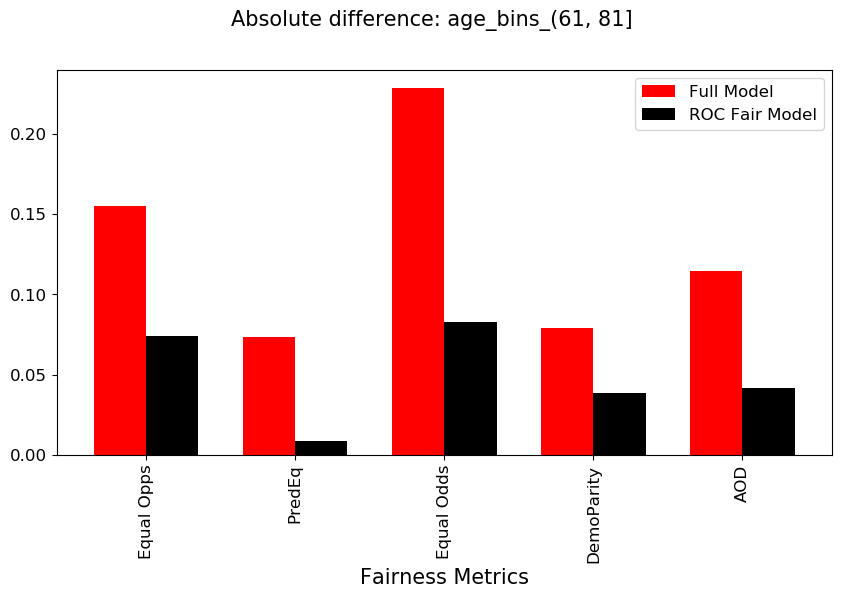

In [144]:
ax = ROC_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['red', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference: {}'.format(choice),  
             fontsize=15, y=1)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Fairness Metrics', fontsize=15)
plt.show()

In [145]:
import XAI_Prototype_Final

In [146]:
from XAI_Prototype_Final import *

In [147]:
!pip install pygam

In [148]:
!pip install dice-ml

In [149]:
dataacf['MARRIAGE_0'].astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    0
29998    0
29999    0
Name: MARRIAGE_0, Length: 30000, dtype: int64

In [150]:
target_variable = "default payment next month"
independent_features = ['LIMIT_BAL', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE_0']

data_new=dataacf[['default payment next month','LIMIT_BAL', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE_0']]
GAM1 = GAM(data_new,independent_features,target_variable)
GAM1.fit()
GAM_train_acc, GAM_test_acc, GAM_summary  = GAM1.predict()

print(f"Train Accuracy: {GAM_train_acc}\n")
print(f"Test Accuracy: {GAM_test_acc}\n")
# print('')

Train Accuracy: 0.8215

Test Accuracy: 0.8211666666666667



In [151]:
GAM1.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    124.3446
Link Function:                        LogitLink Log Likelihood:                                -10272.0833
Number of Samples:                        24000 AIC:                                            20792.8557
                                                AICc:                                           20794.1824
                                                UBRE:                                               2.8705
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1887
Feature Function                  Lam

In [152]:
data_new['MARRIAGE_0']=data_new['MARRIAGE_0'].astype('int64',copy=False)

In [153]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   default payment next month  30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   PAY_0                       30000 non-null  int64
 4   PAY_2                       30000 non-null  int64
 5   PAY_3                       30000 non-null  int64
 6   PAY_4                       30000 non-null  int64
 7   PAY_5                       30000 non-null  int64
 8   PAY_6                       30000 non-null  int64
 9   BILL_AMT1                   30000 non-null  int64
 10  BILL_AMT2                   30000 non-null  int64
 11  BILL_AMT3                   30000 non-null  int64
 12  BILL_AMT4                   30000 non-null  int64
 13  BILL_AMT5                   30000 non-null  int64
 14  BILL_A

In [154]:
CF2 = CF(data_new,independent_features,target_variable)
CF2.fit()
CF2.dice_ml()

In [167]:
# CF2.CF_EXP()

In [156]:
full_model = IV_PDP(data_new,independent_features,target_variable)
full_model.fit()
full_model_predictions = full_model.predict()

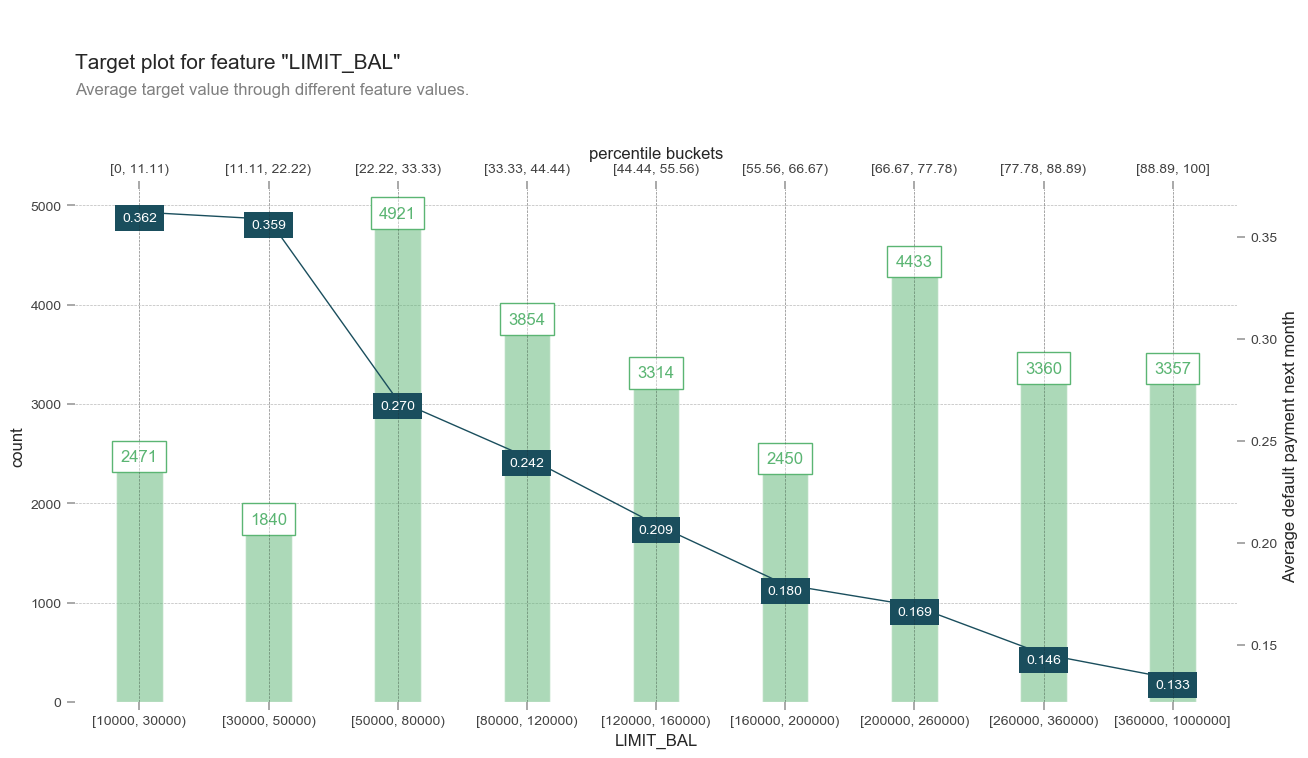

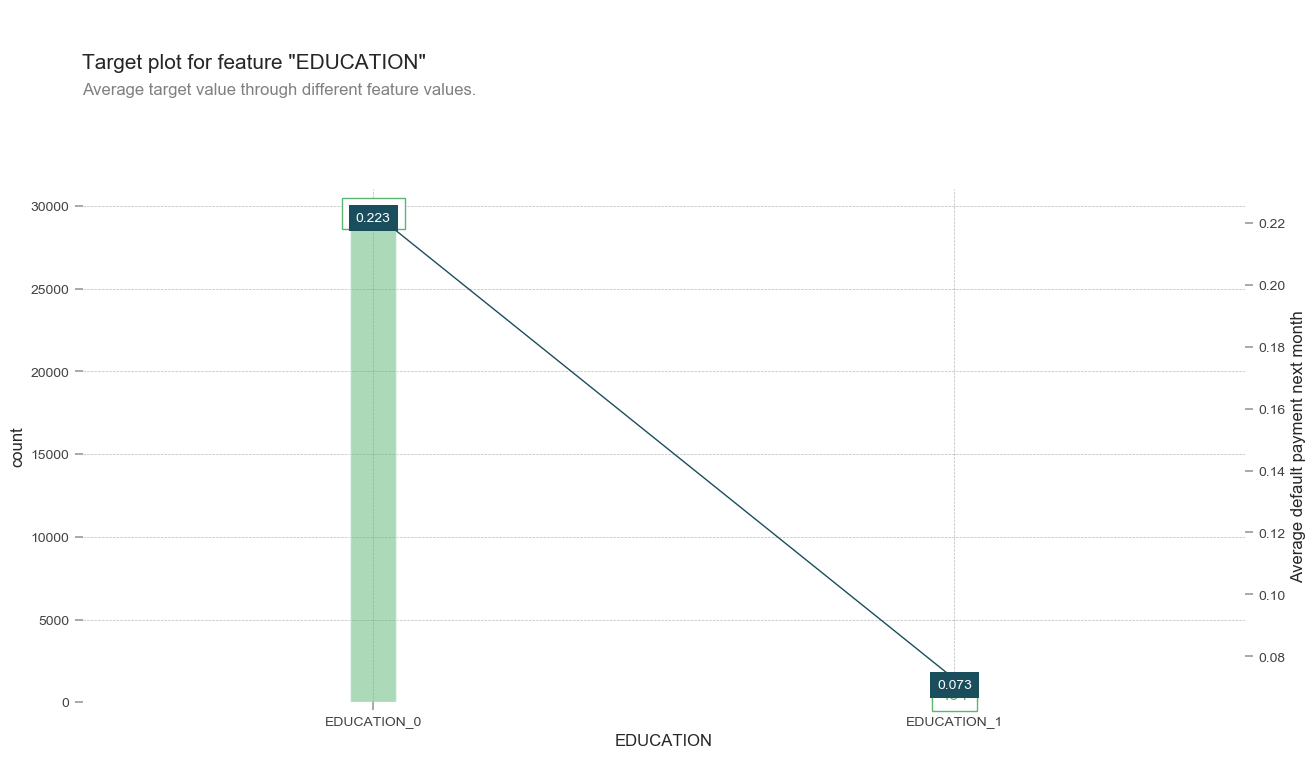

In [157]:
full_model.EDA_PLOT()

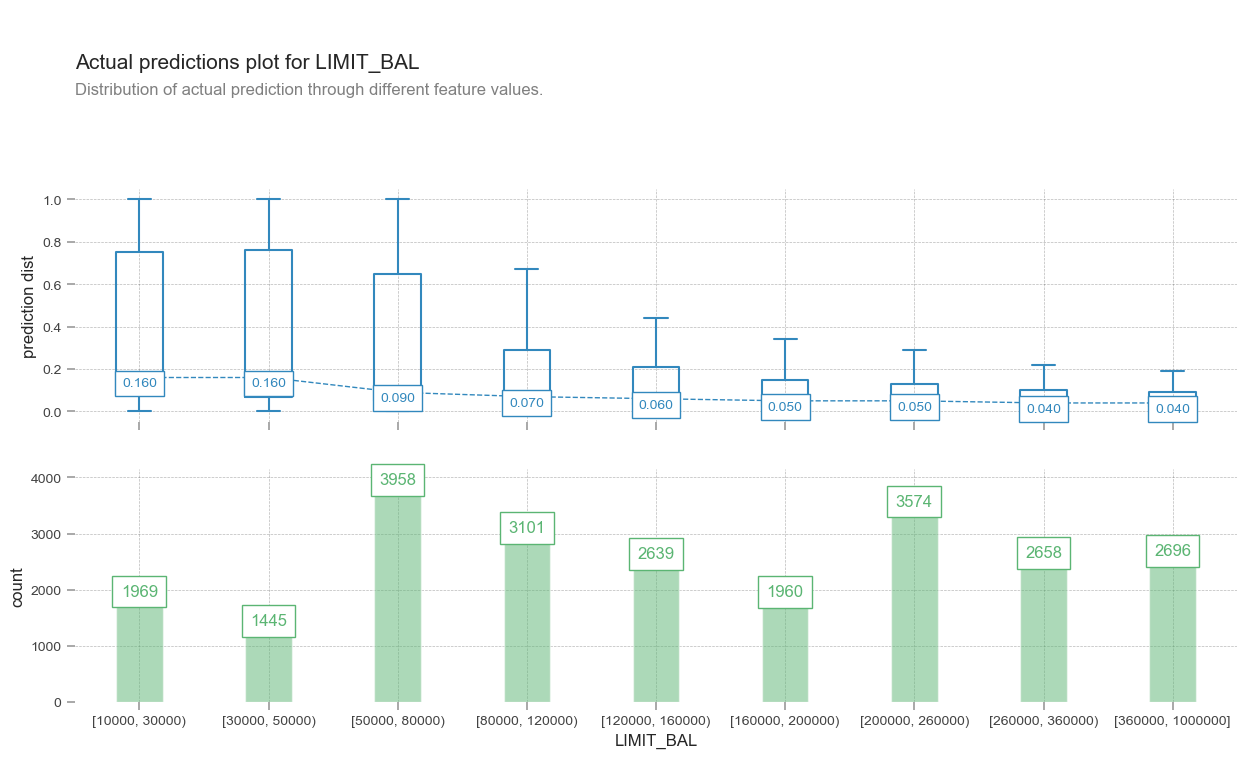

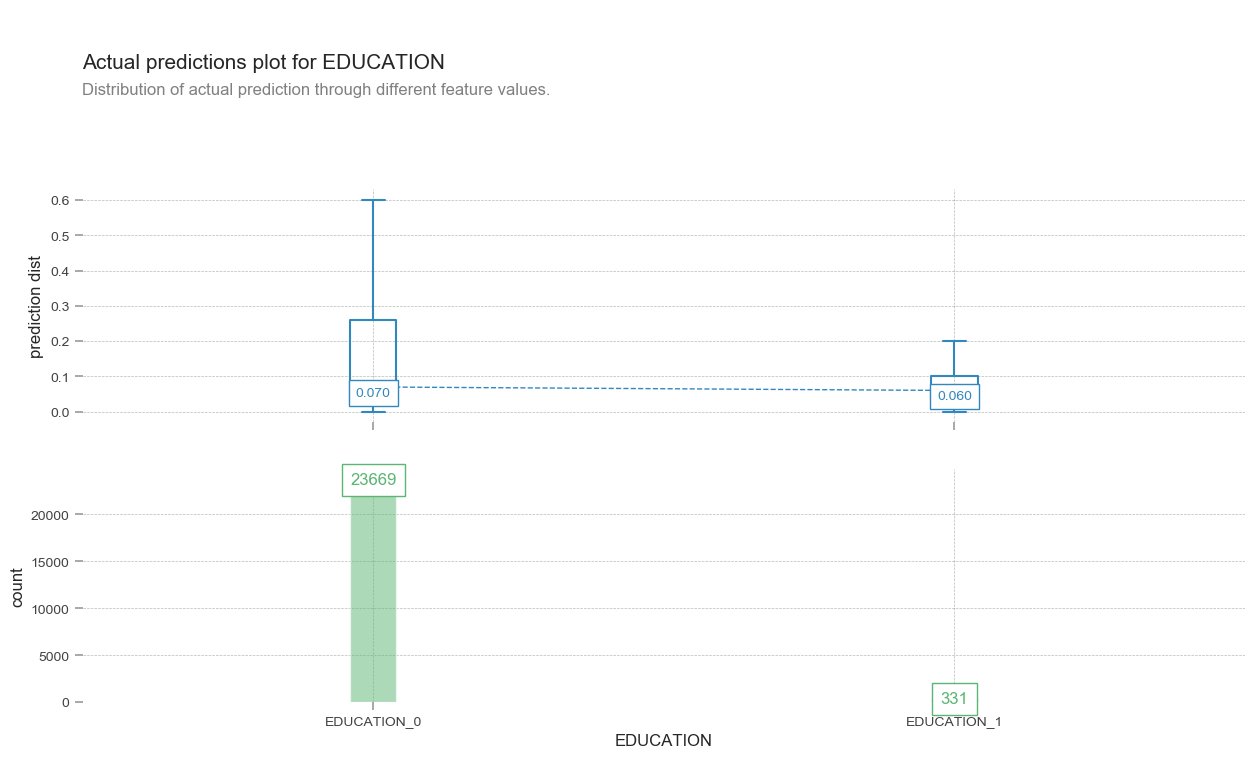

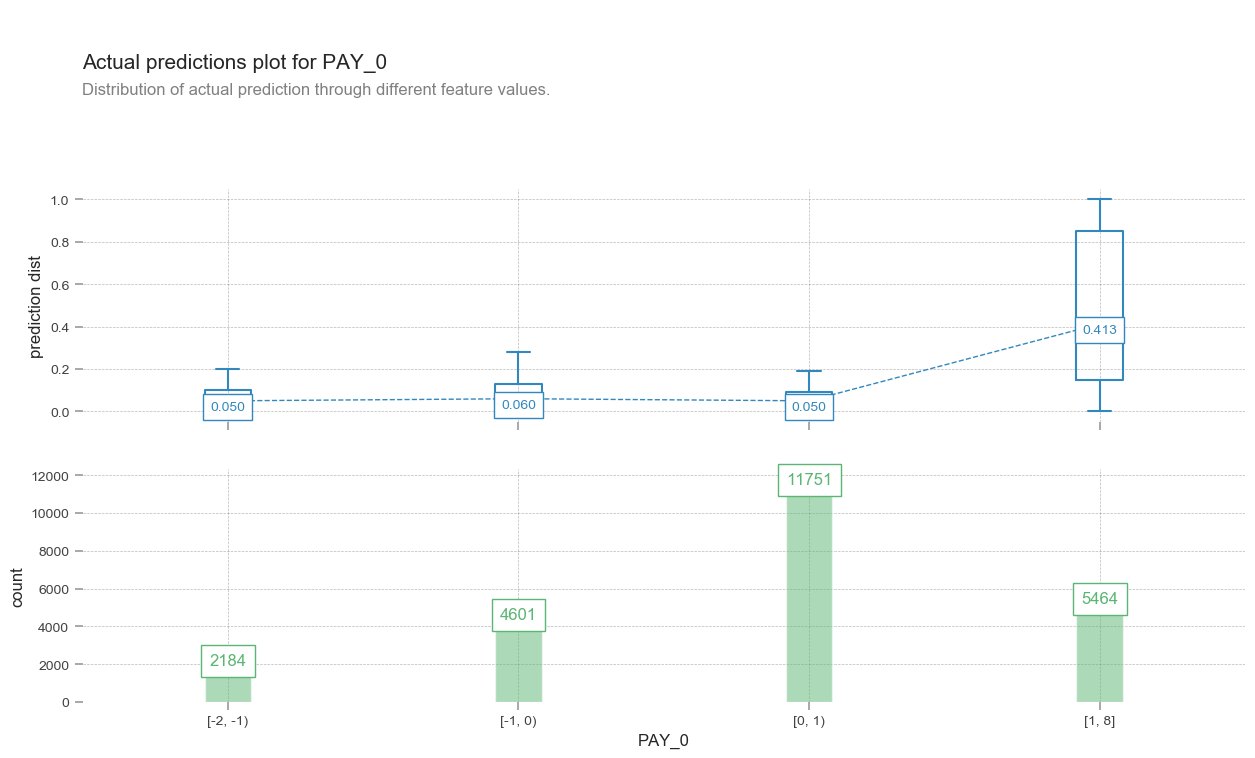

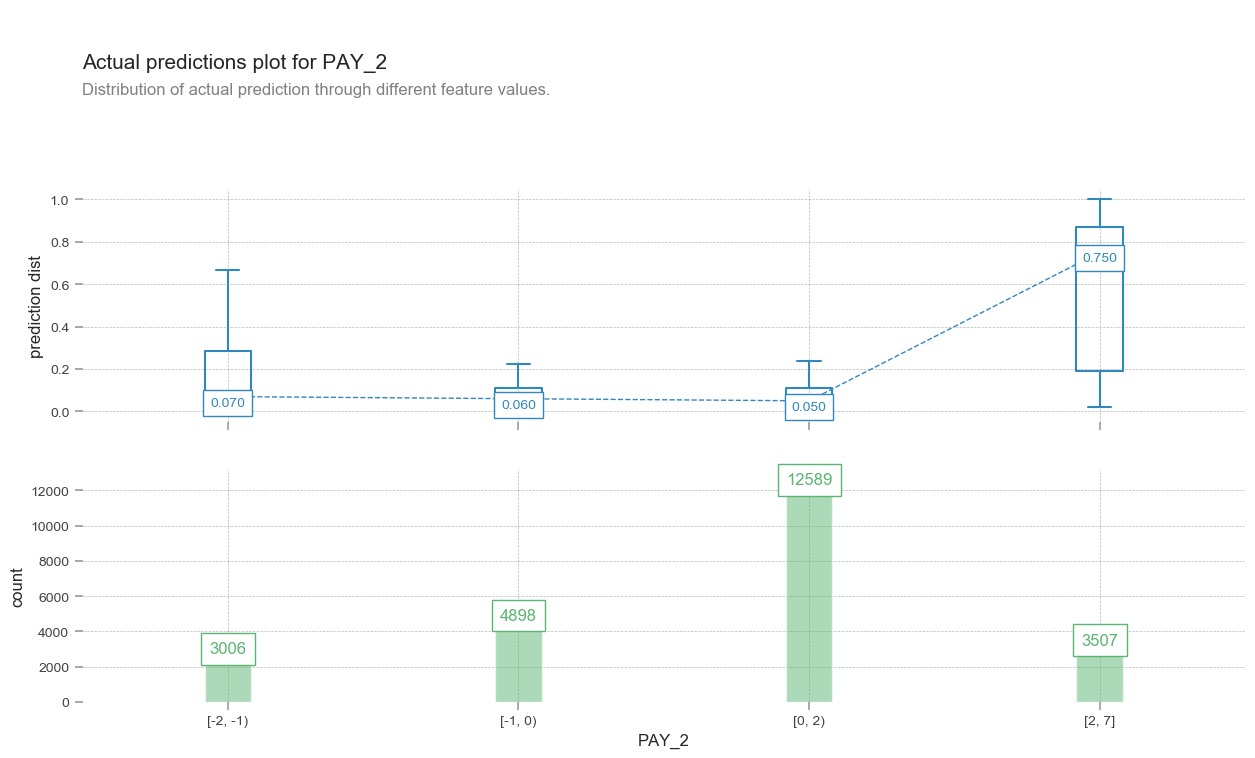

In [158]:
full_model.IV_PLOT()

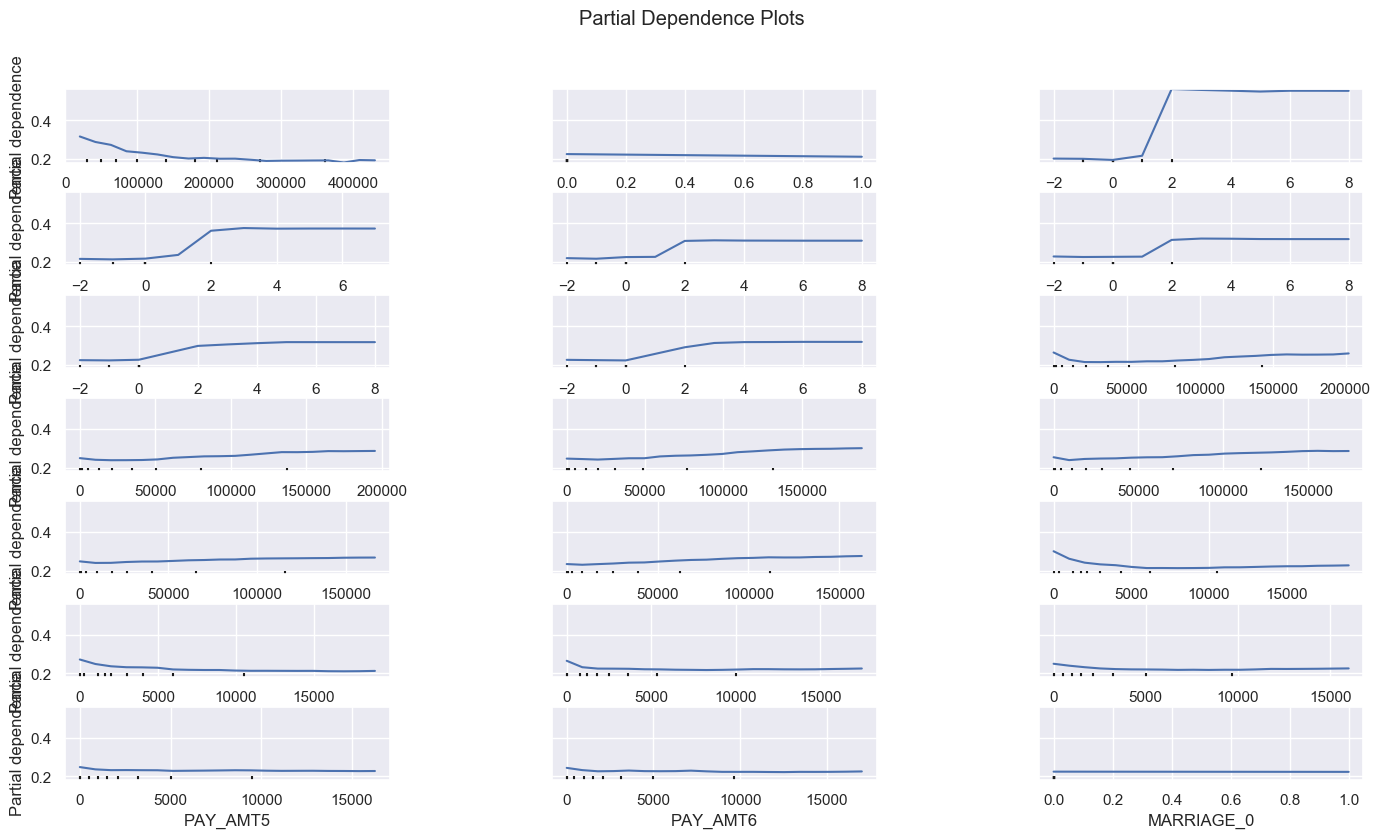

In [159]:
full_model.PDP_PLOT()

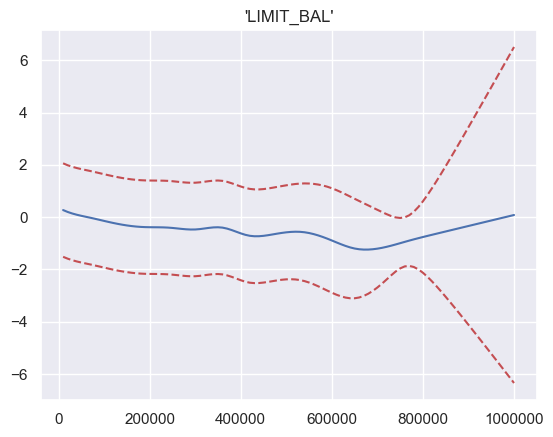

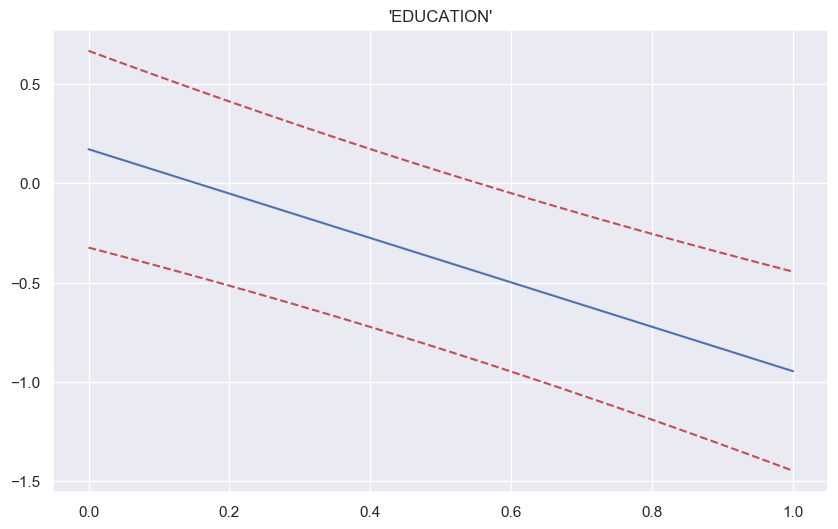

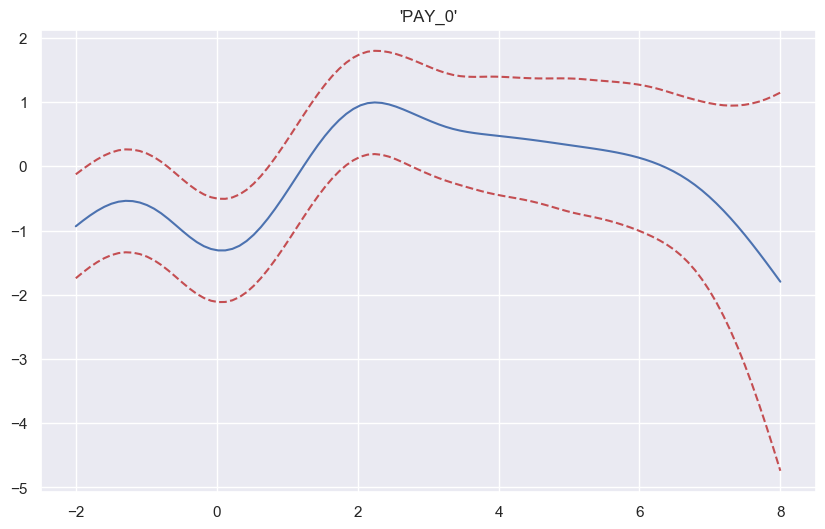

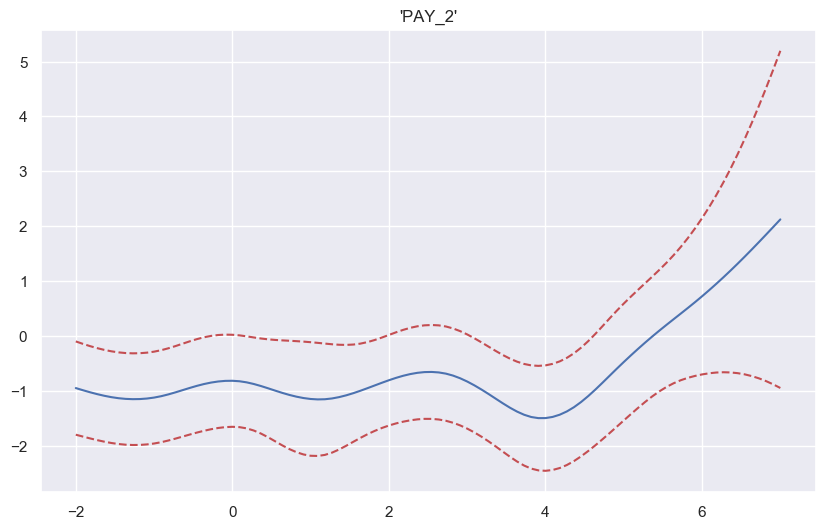

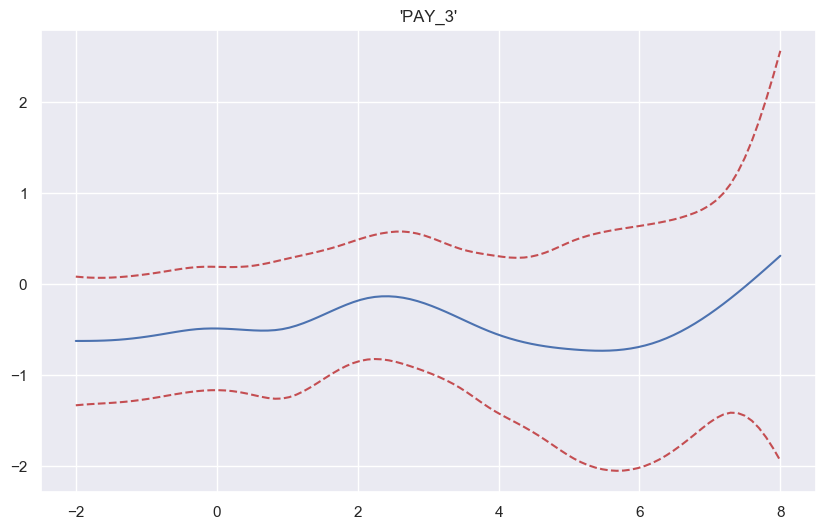

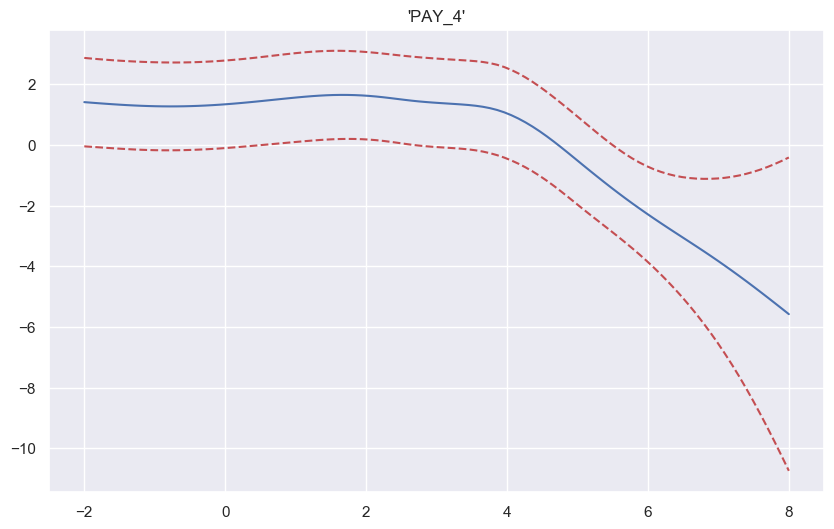

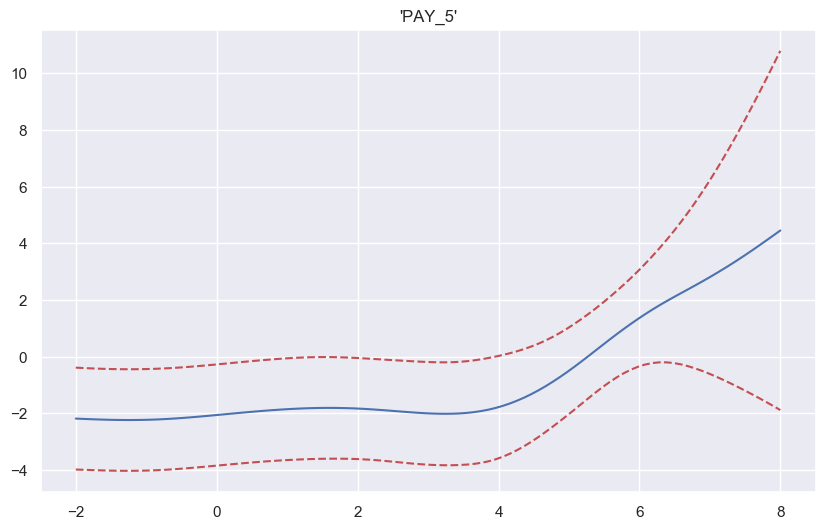

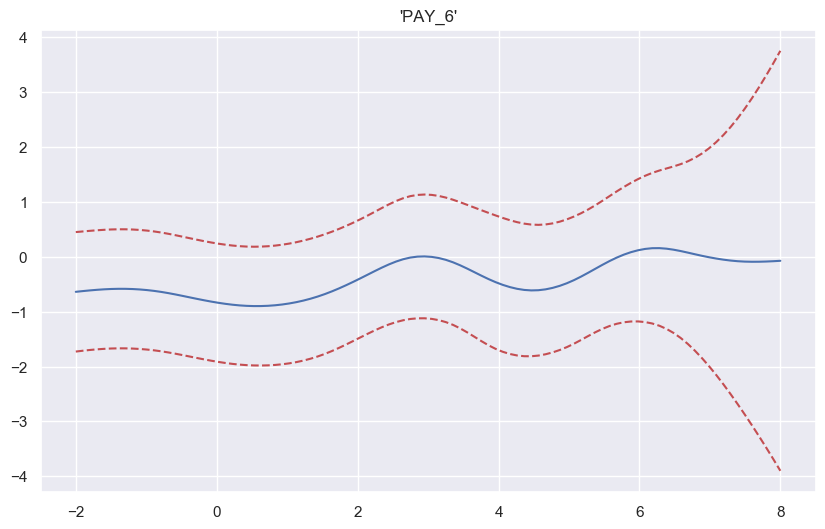

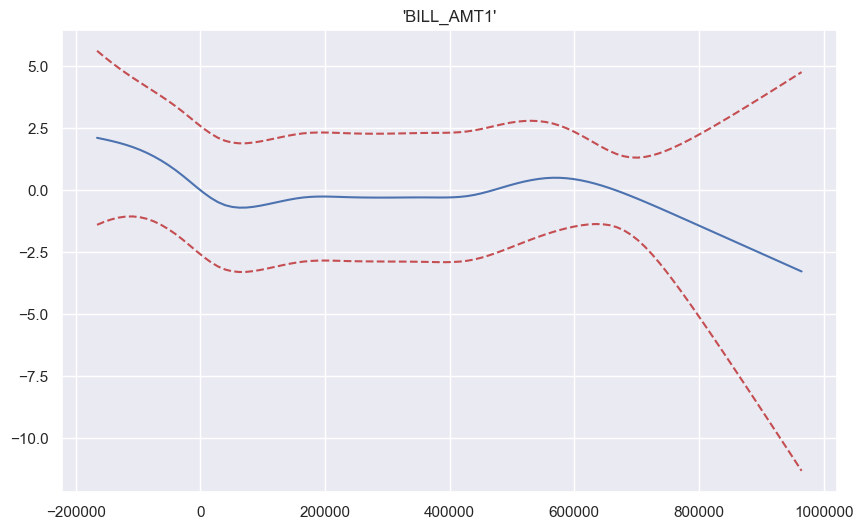

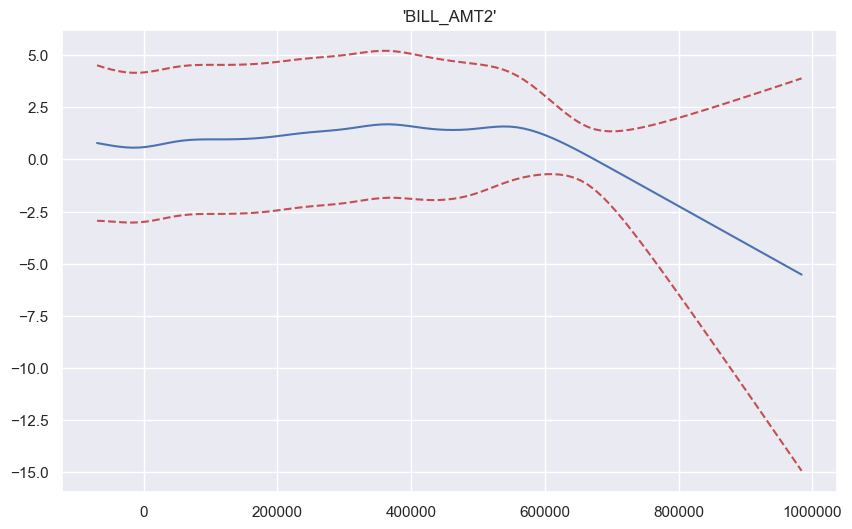

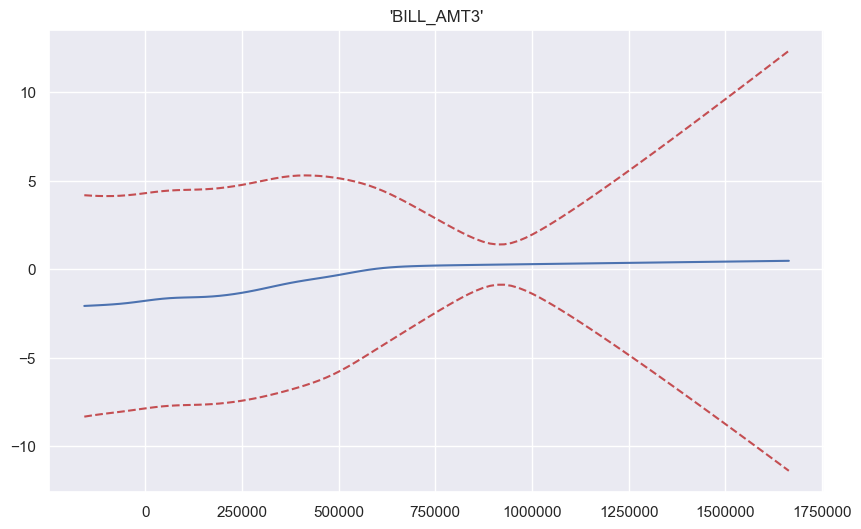

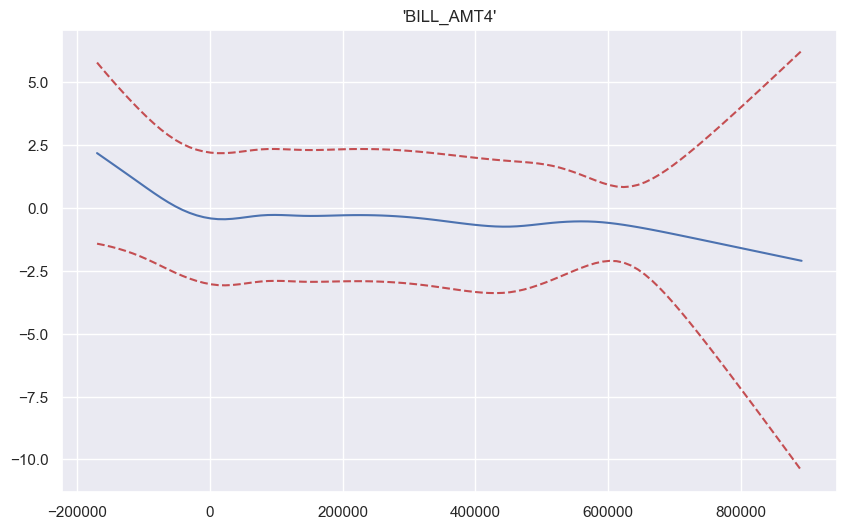

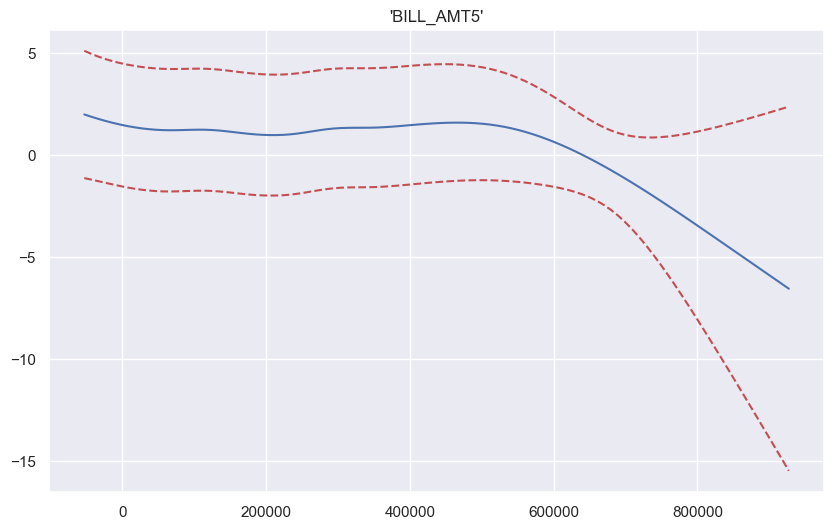

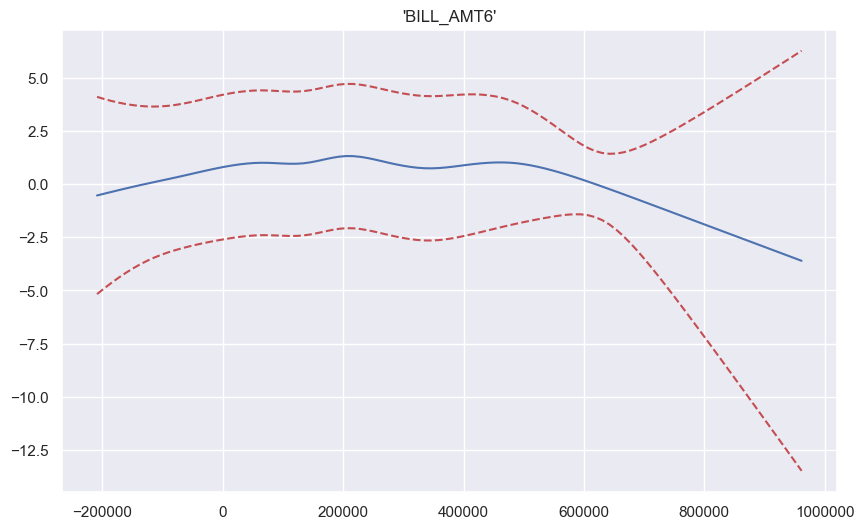

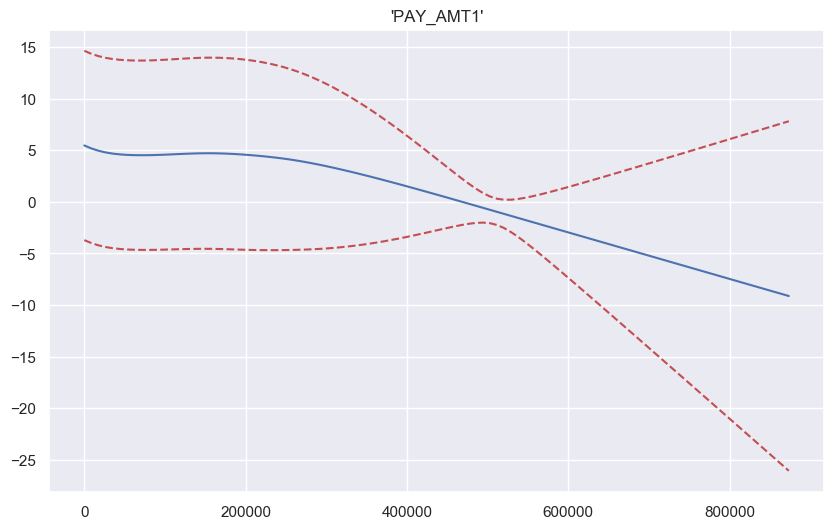

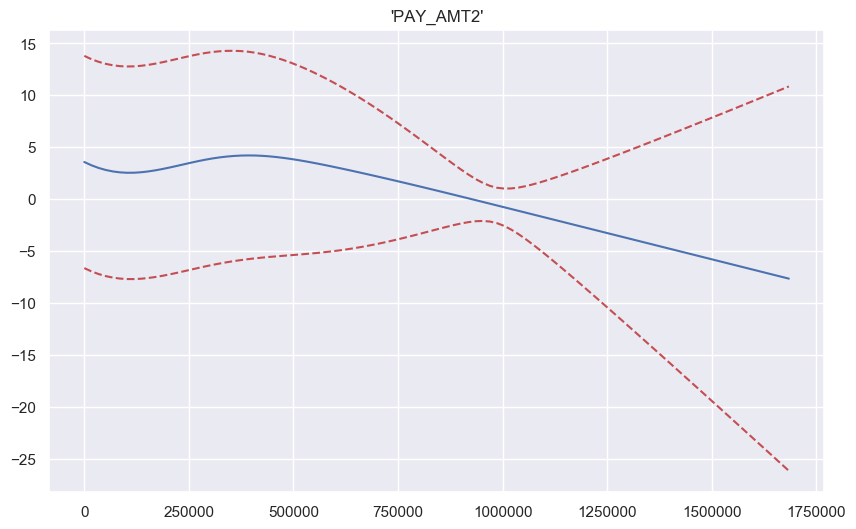

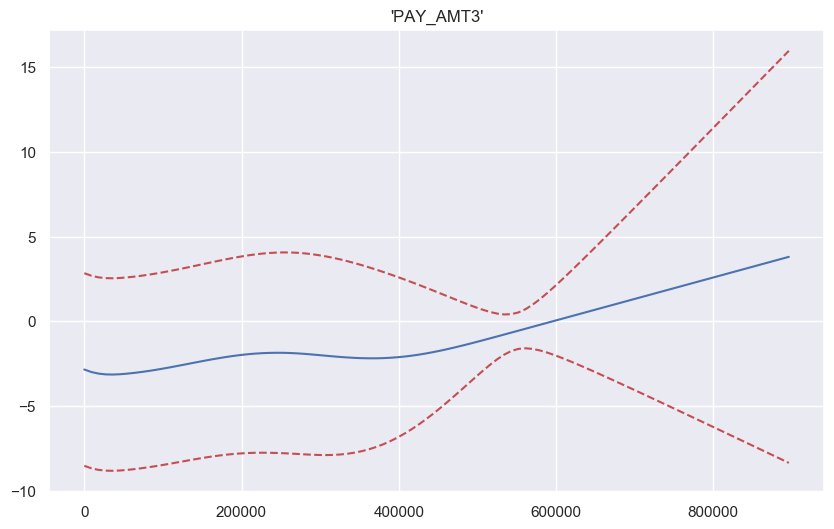

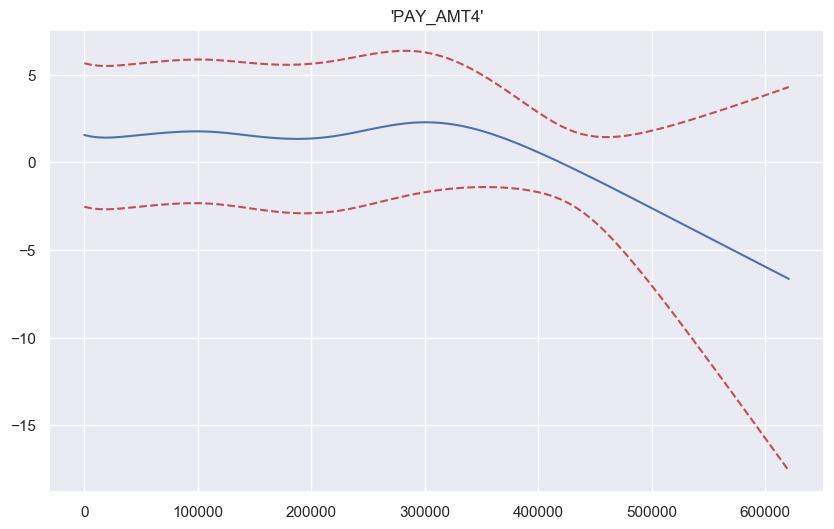

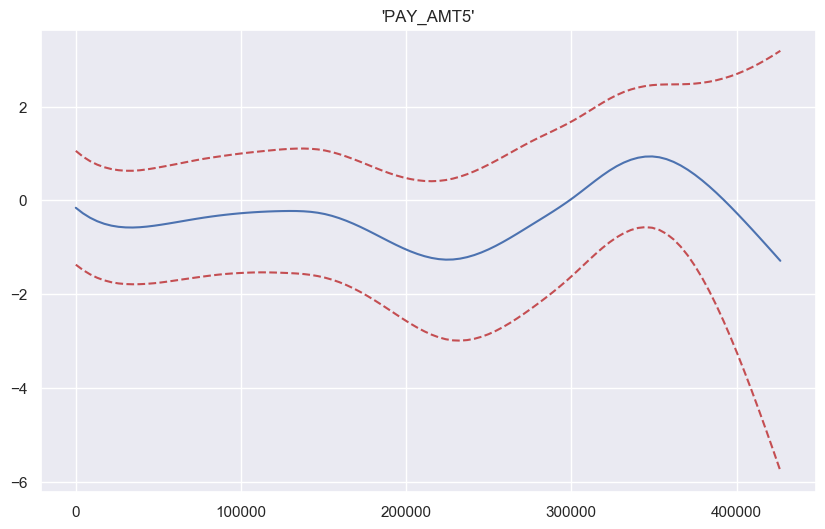

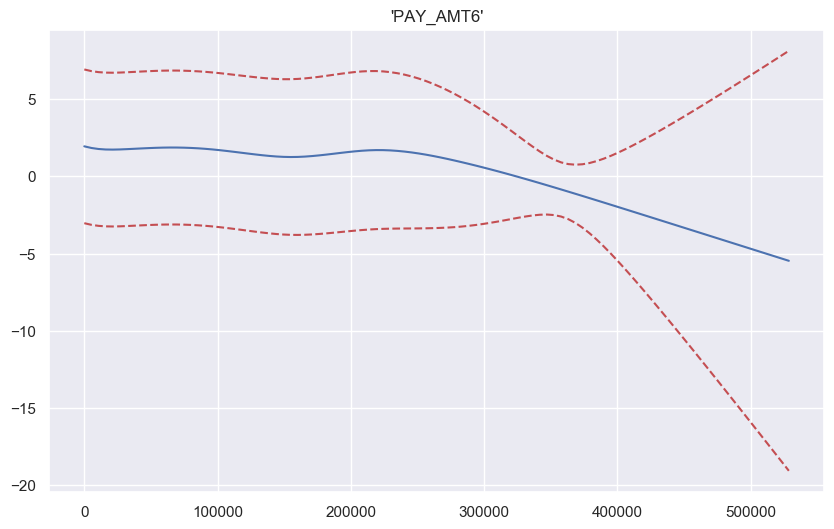

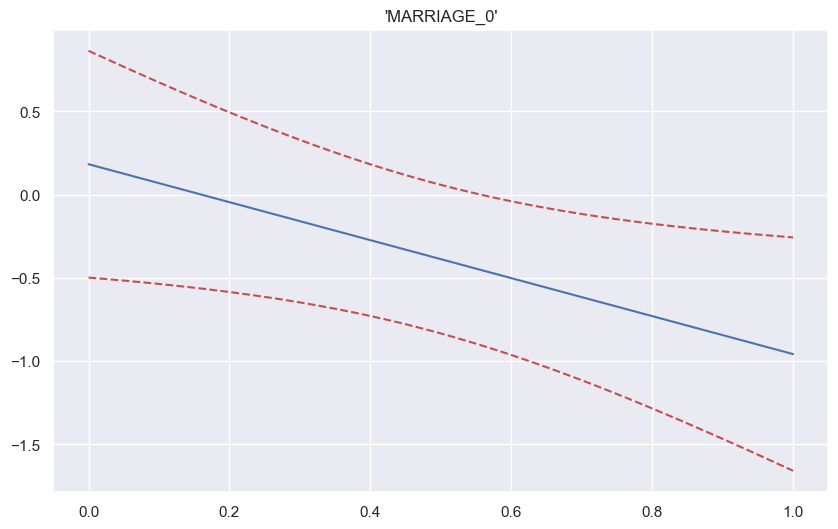

In [161]:
GAM1.GAM_PLOT()

In [162]:
def ret_tag(val):
        for i in range(10):
            if val in categories[i]:
                return tags[i]
        
def zero_list_maker(n):
        list_of_zeros = [0] * n
        return list_of_zeros

In [163]:
def bar_width_per_quantile2(SCQ_view, label_filter):
    view_filtered = SCQ_view[SCQ_view['default payment next month'] == label_filter]      
    view_filtered['Tag'] = view_filtered['Score2'].map(lambda x: ret_tag(x))
    len_view_filtered = len(view_filtered)
    view_filtered['ID']=view_filtered.index
    count_pertag_filtered = view_filtered[['ID', 'Tag']].groupby(['Tag']).count().rename(columns={'ID': 'Count'})
    count_pertag_filtered['Perc'] = count_pertag_filtered['Count'] / len(SCQ_view) * 100

    Amt = view_filtered[['ID', 'Tag', 'Amount']].groupby(['Tag'])['Amount'].sum()
    Amt = (Amt/1000).to_list()
    sc = count_pertag_filtered['Perc'].tolist()
    sc = zero_list_maker(10 - len(sc)) + sc 
    return sc, Amt  

In [164]:
SCQ2 = SCQ(data_new,independent_features,target_variable)
SCQ2.fit()
SCQ_predictions = SCQ2.predict()
SCQ_view = SCQ2.create_view("LIMIT_BAL",'Score',['default payment next month','Score','Amount'])

#2 For ret_tags, zero_lists and Categories
i=5
cuts_by_quantile = pd.qcut(SCQ_view['Score2'], 11, duplicates='drop') 
categories = cuts_by_quantile.value_counts().index.categories
left_bounds = categories.left
right_bounds = categories.right
tags = range(1, 11)

#3 For class bar_width_per_quantile2
sc1, amt1 = bar_width_per_quantile2(SCQ_view, 1)
sc0, amt0 = bar_width_per_quantile2(SCQ_view, 0)

#Defining dataframes for plotting
name = [str(left_bounds[i])+'-'+str(right_bounds[i]) for i in range(10)]

data_p = [(name[i], sc1[i], sc0[i]) for i in range(10)]
data_amt = [(name[i], amt1[i], amt0[i]) for i in range(10)]

df1 = pd.DataFrame(columns=["Range","Label 1", "Label 0"],data=data_p)
df2 = pd.DataFrame(columns=["Range", 'Amount:1', "Amount:0"],data=data_amt)

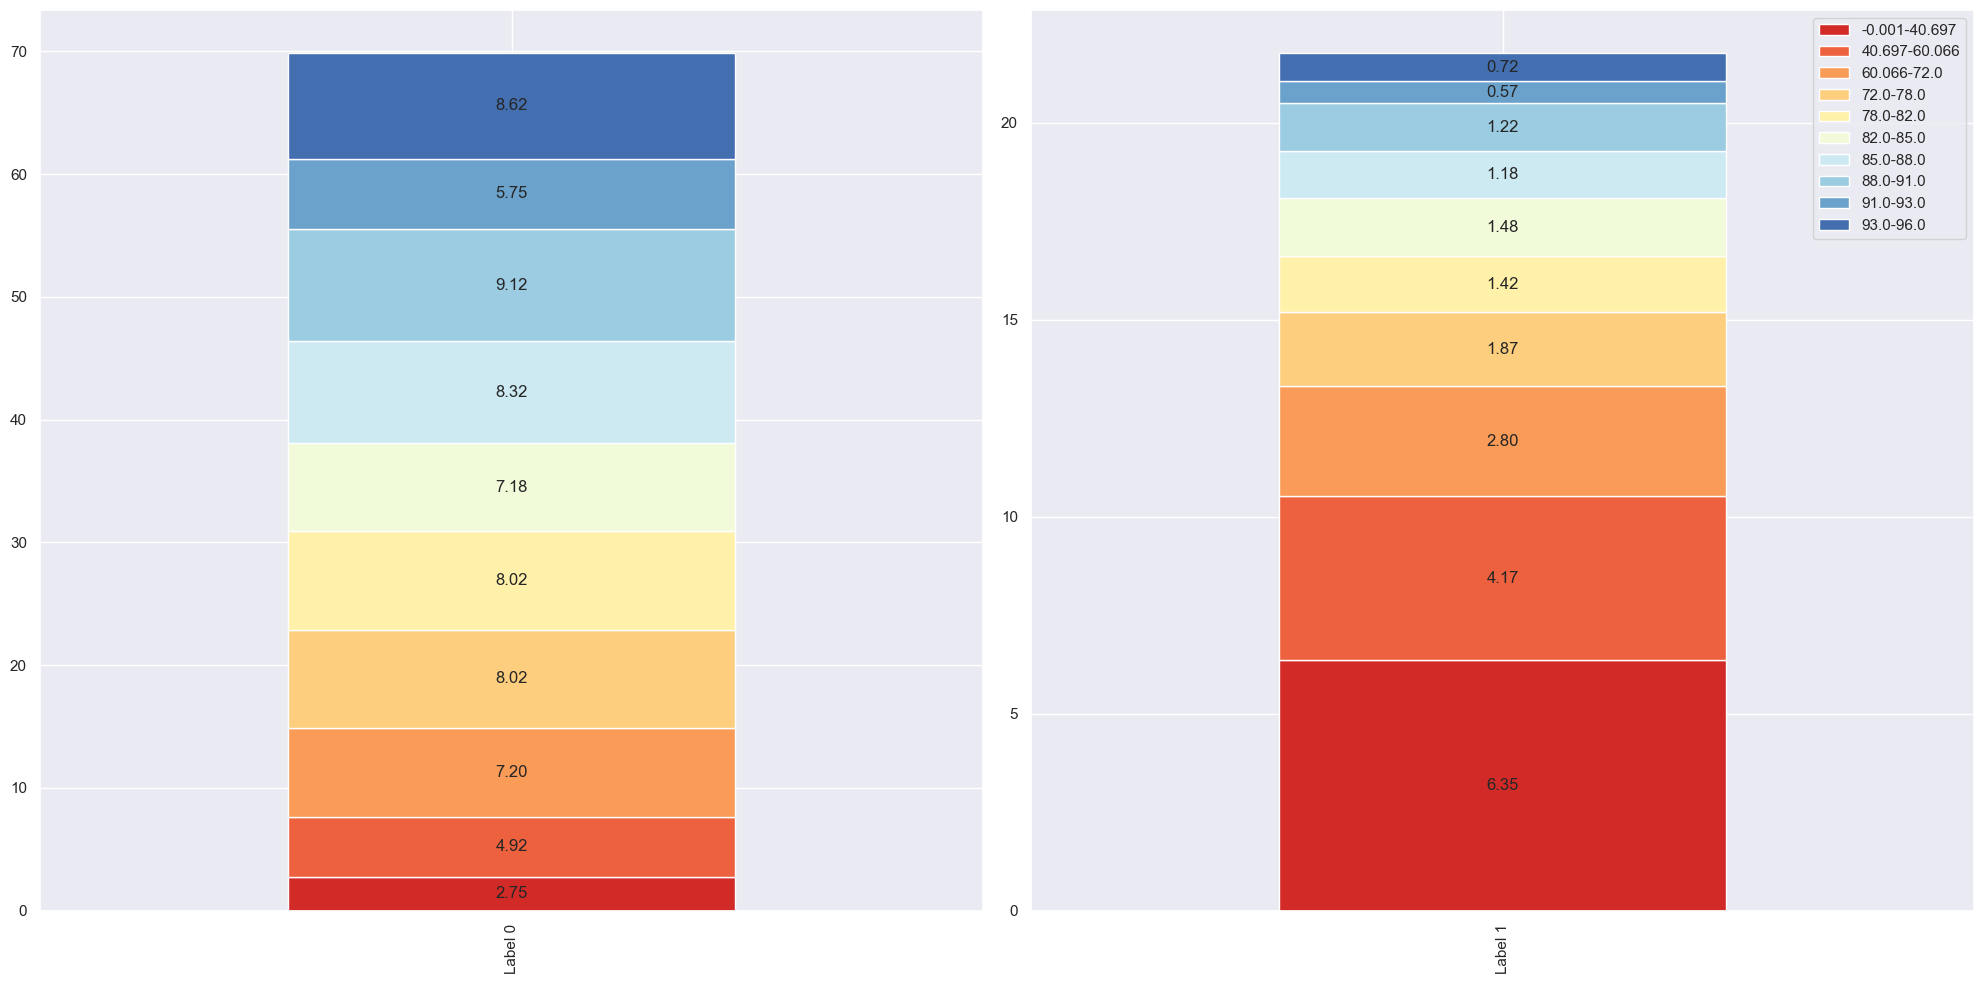

In [165]:
Show_quantile_label(df1,None)

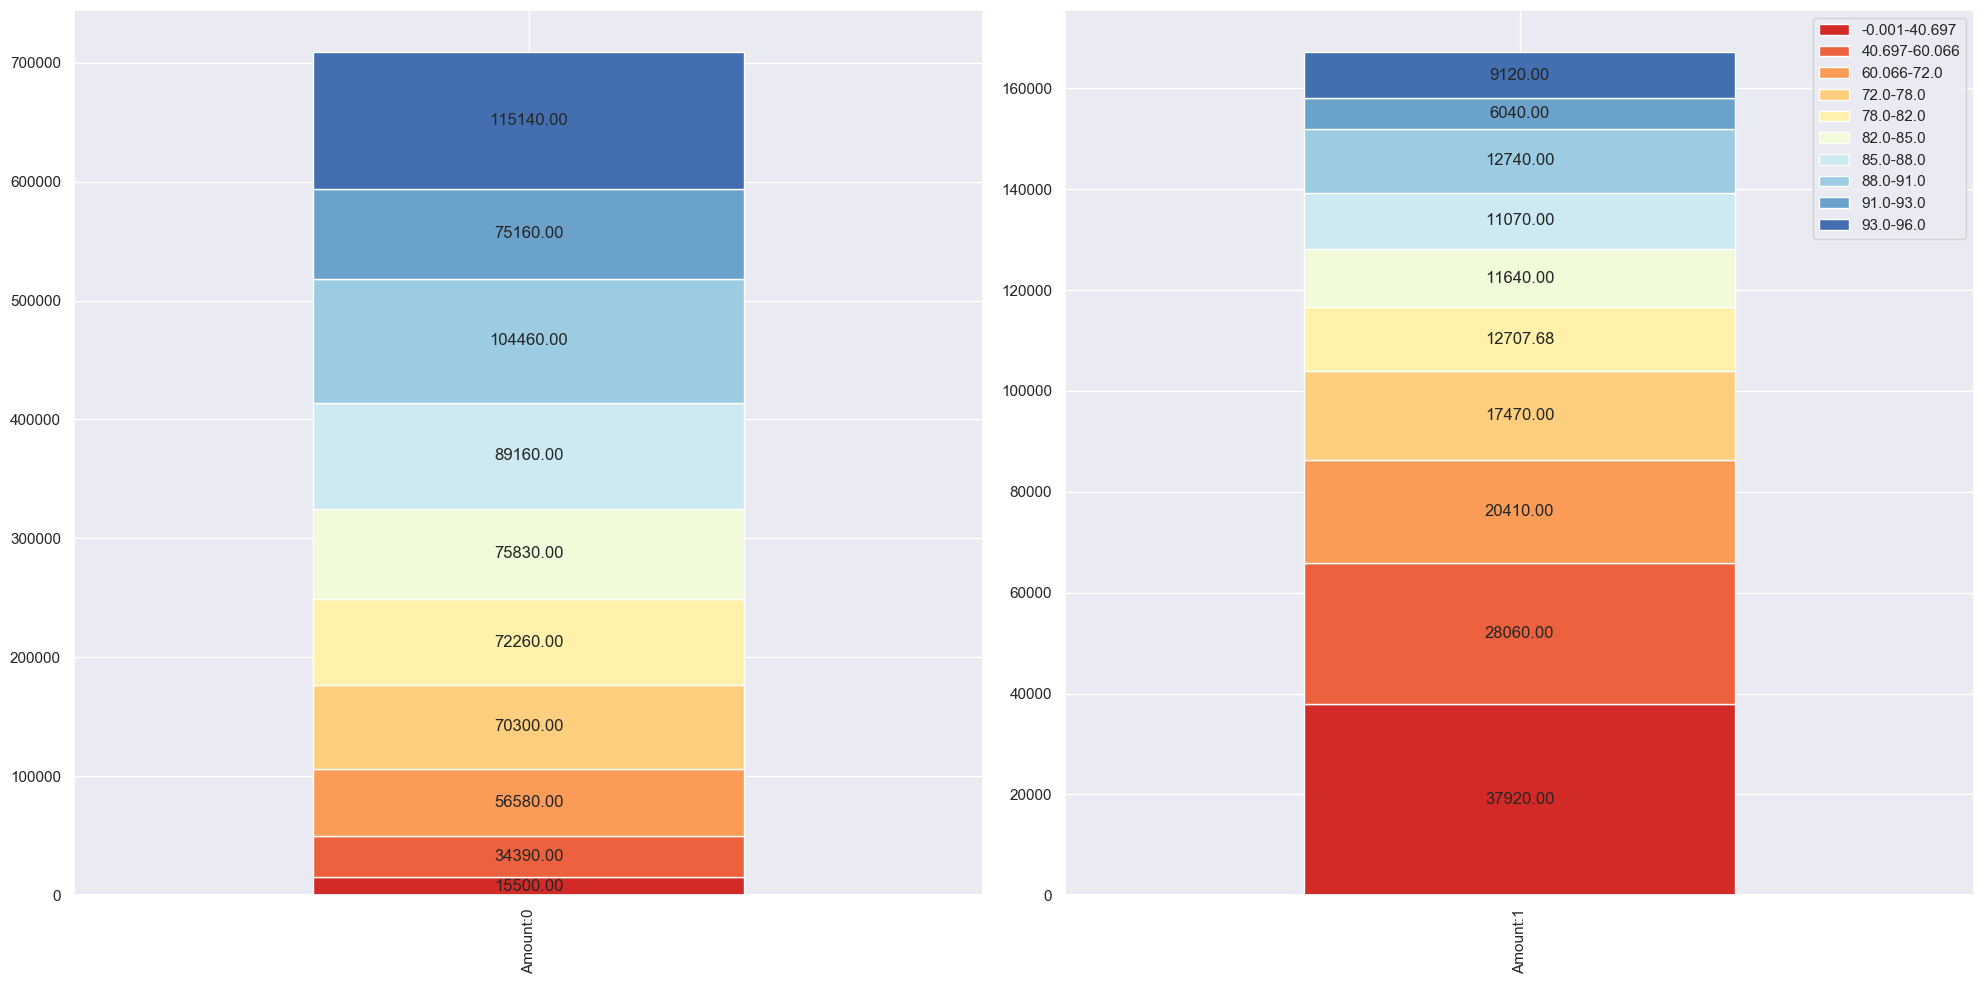

In [166]:
Show_quantile_label(None,df2)